In [1]:
library(ggplot2)
library(reshape2)
library(dplyr)
library(ggpubr)
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
source("../../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: magrittr
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: iterators
Loading required package: parallel

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following objects are masked from ‘package:reshape2’:

    dcast, melt

Loading required package: prodlim

 randomForestSRC 2.9.0 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 

Loading required package: RColorBrewer
Loading required package: lattice
Loading required package: Formula

Attaching package: ‘Hmisc’

The following object is masked from ‘package:randomForestSRC’:

    impute

The following objects are masked from ‘package:dplyr’:

    src, summarize

In [2]:
colors <- c("Components" = "#EE9937", "ELN Recommendation 2017" = "#5C5C5C", "comp" = "#870C14", "eln_comp" = "#BFBFBF",
         "eln_gen" = "#59A08B", "eln_cyto" = "#2b8cbe", "eln_gen_cyto" = "#a6bddb", "eln_gen_cyto_comp" = "#fdbb84",
         "comp_gen" = "grey45", "comp_cyto" = "#e79f00", "comp_gen_cyto" = "#009E73", "cyto" = "#0072B2",
         "gen" = "#CC79A7", "gen_cyto" = "#9ad0f3", "eln_age" = "#D55E00", "eln_demo" = "lightskyblue","eln_clin" = "mistyrose4", "eln_clin_demo" = "darkseagreen","comp_age" = "lightgoldenrod","comp_clin" = "lightsalmon","comp_demo" = "#F0E442","comp_clin_demo" = "firebrick3","comps" = "#000000")
is.element("Components",names(colors))

[1] TRUE

In [3]:
SVM <- read.table("../Prognosis_results_ITD/SVM.csv",sep=',',header=T)

In [20]:
### Useful function for Comparison
#  colors <- c("Components" = "#EE9937", "ELN Recommendation 2017" = "#5C5C5C", "comp" = "#870C14", "eln_comp" = "#BFBFBF",
#          "eln_gen" = "#59A08B", "eln_cyto" = "#2b8cbe", "eln_gen_cyto" = "#a6bddb", "eln_gen_cyto_comp" = "#fdbb84",
#          "comp_gen" = "grey45", "comp_cyto" = "#e79f00", "comp_gen_cyto" = "#009E73", "cyto" = "#0072B2",
#          "gen" = "#CC79A7", "gen_cyto" = "#9ad0f3", "eln_age" = "#D55E00", "eln_demo" = "lightskyblue","eln_clin" = "mistyrose4", "eln_clin_demo" = "darkseagreen","comp_age" = "lightgoldenrod","comp_clin" = "lightsalmon","comp_demo" = "#F0E442","comp_clin_demo" = "firebrick3","comps" = "#000000")

comparison <-function(models = list(c("eln","comp")), remove_RFX_ = F ,x = 25, y = 8 ,tests="",color="",FUN=median ){
       options(warn=-1)
    with_colors = T
    df_comparison <- cbind(read.table(paste(paste("../Prognosis_results_ITD/",models[1],sep=""),".tsv",sep="")),SVM=SVM[,models[1]])
    df_comparison$model <- ifelse(models[1]=="eln","ELN Recommendation 2017",
                         ifelse(models[1]=="comp","Components",models[1]))
    for (mod in models[-1]){
        
        tmp <- cbind(read.table(paste(paste("../Prognosis_results_ITD/",mod,sep=""),".tsv",sep="")),SVM=SVM[,mod])
        tmp$model <- ifelse(mod=="eln","ELN Recommendation 2017",
                         ifelse(mod=="comp","Components",mod))
        if(with_colors){
                with_colors = is.element(unique(tmp$model),names(colors))
        }
        df_comparison <- rbind(df_comparison,tmp)
    }
    df_comparison <- melt(df_comparison,id='model')
    if (remove_RFX_){df_comparison <- df_comparison[df_comparison$variable!= "RFX_",]}
    df_comparison $title <- "Detailed Comparison"
    df_comparison$title_bis <- "Summary Comparison"
    
    
    
    
    set_notebook_plot_size(x,y)
    p1 <- ggplot(df_comparison,aes(x=variable,y=value)) + geom_boxplot(aes(fill = model), notch=F)+
    theme(strip.text = element_text(size=30),legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8,size=20),axis.text.y = element_text(size = 20),
         axis.title.x=element_text(size=30),axis.title.y=element_text(size=30),legend.title=element_text(size=30),legend.text=element_text(size=20)) +
    ylab("C-Index") + xlab("") + facet_wrap( ~ title) + try(if(length(color)>1){scale_fill_manual(values=color)})
    
    p2 <- ggplot(df_comparison, aes(x=reorder(model,-value,FUN=FUN),y=value))+
    geom_boxplot(aes(fill =model), notch=F)+
    theme(strip.text = element_text(size=30),legend.position="none",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8,size=15),axis.text.y = element_text(size = 15),
             axis.title.x=element_text(size=30),axis.title.y=element_text(size=30),legend.title=element_text(size=30),legend.text=element_text(size=20))+
    #
     stat_compare_means(paired=F,comparison=tests,method="wilcox.test",label="p.signif")+
             #symnum.args = list(cutpoints = c(0, 0.0001, 0.001, 0.01,0.1, 0.15, 1), symbols = c("*****","****", "***", "**", "*", "ns")))+
             #,+
    xlab("")+ylab("C-Index")+ facet_wrap( ~ title_bis) + try(if(length(color)>1) {scale_fill_manual(values=color)})#+scale_y_continuous(limits = quantile(df_comparison$value, c(0.1, 0.9)))
    return(list(p1,p2))
}

# FIGURES

# Figure A : ELN effects

[[1]]

[[2]]


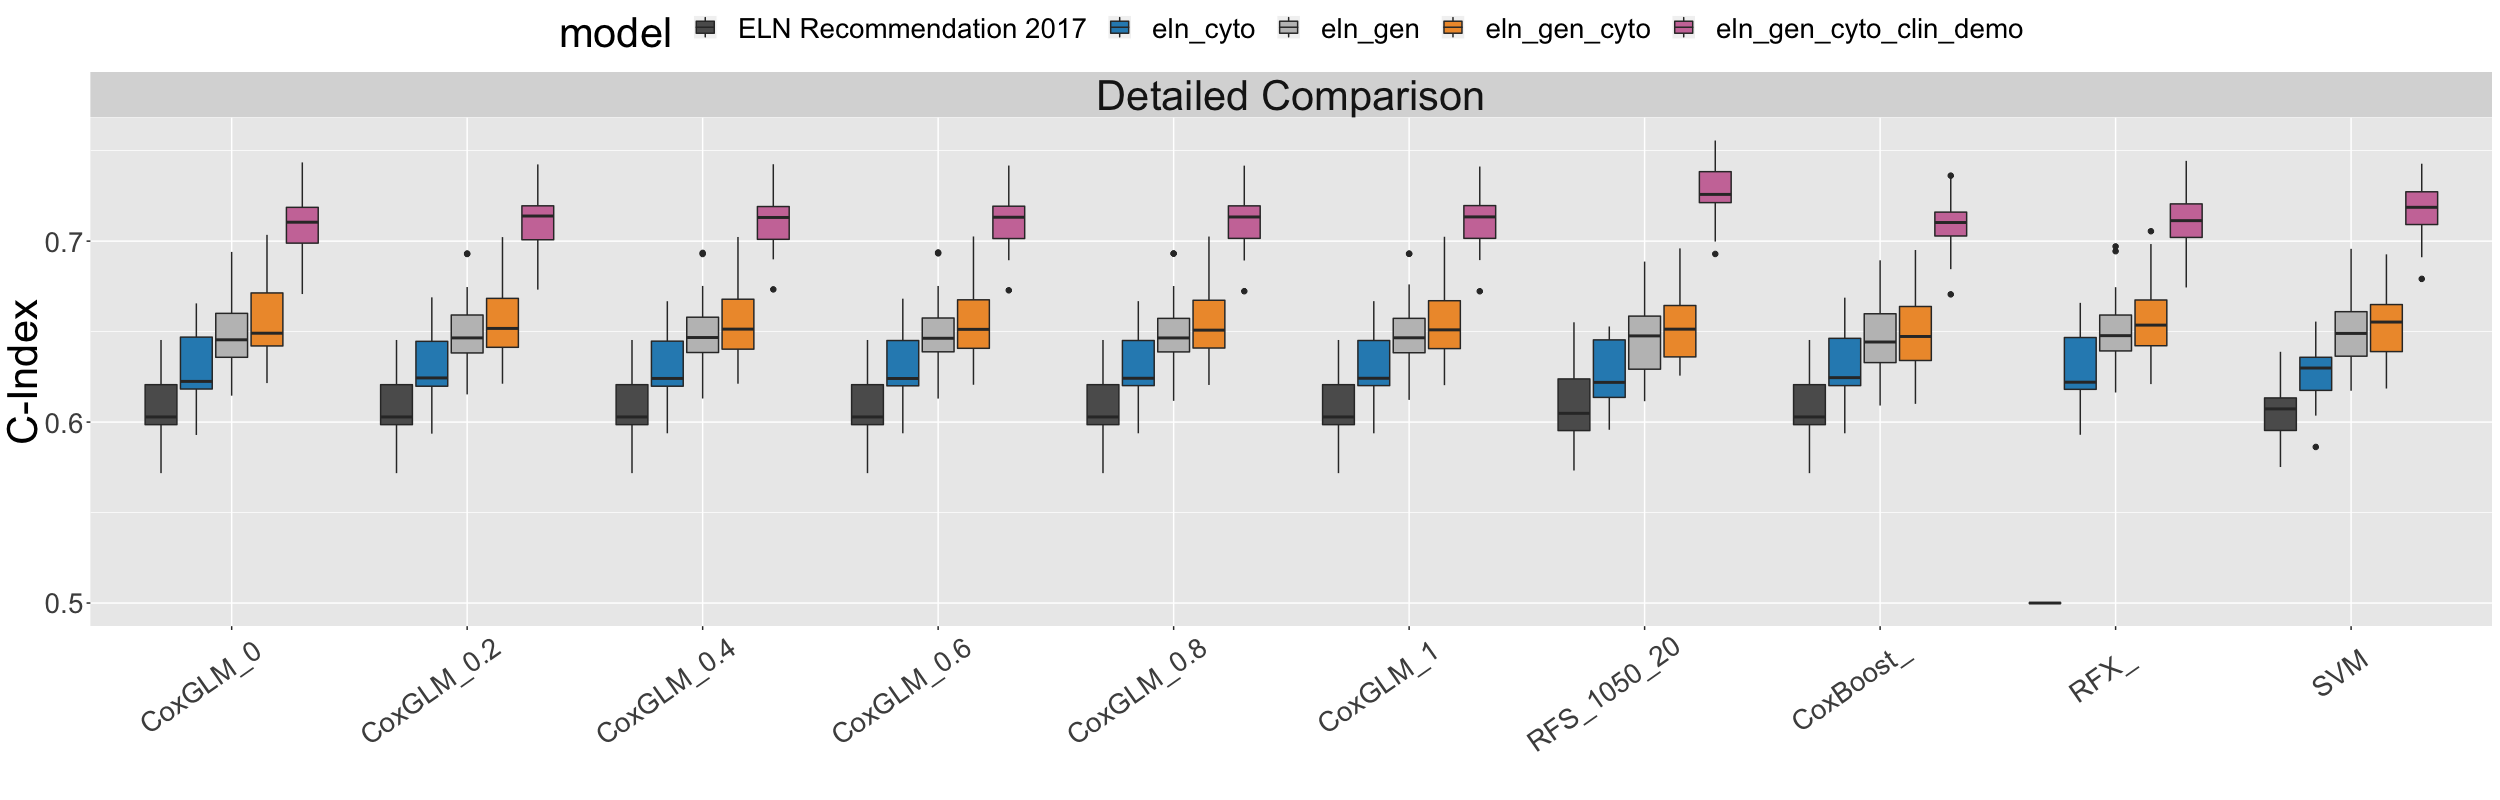

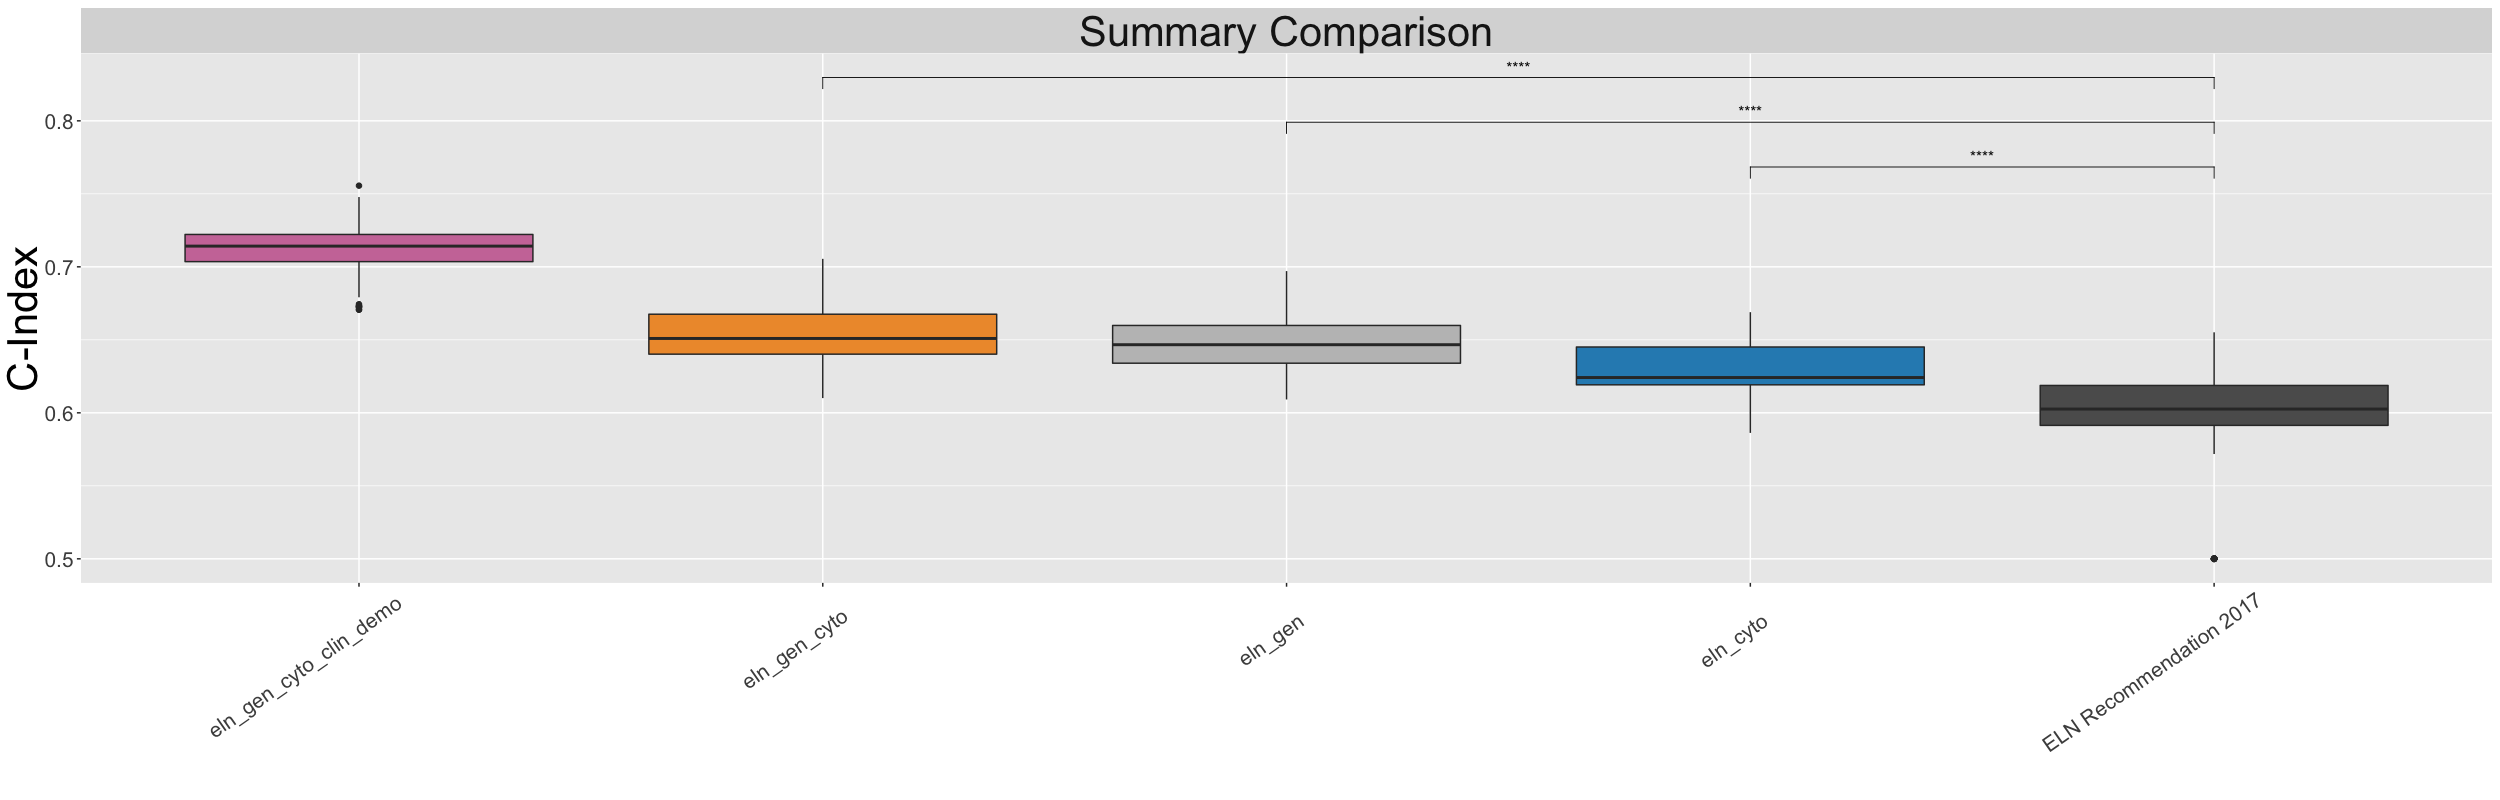

In [13]:
comparison(c("eln","eln_cyto","eln_gen","eln_gen_cyto","eln_gen_cyto_clin_demo"),tests=list(c("ELN Recommendation 2017","eln_cyto"),c("ELN Recommendation 2017","eln_gen"),c("ELN Recommendation 2017","eln_gen_cyto")),
          color=c("ELN Recommendation 2017"="#5C5C5C","eln_cyto"="#2b8cbe","eln_gen"="#BFBFBF","eln_gen_cyto"="#EE9937","eln_gen_cyto_clin_demo"="#CC79A7"))

# Figure B : Components effects

[[1]]

[[2]]


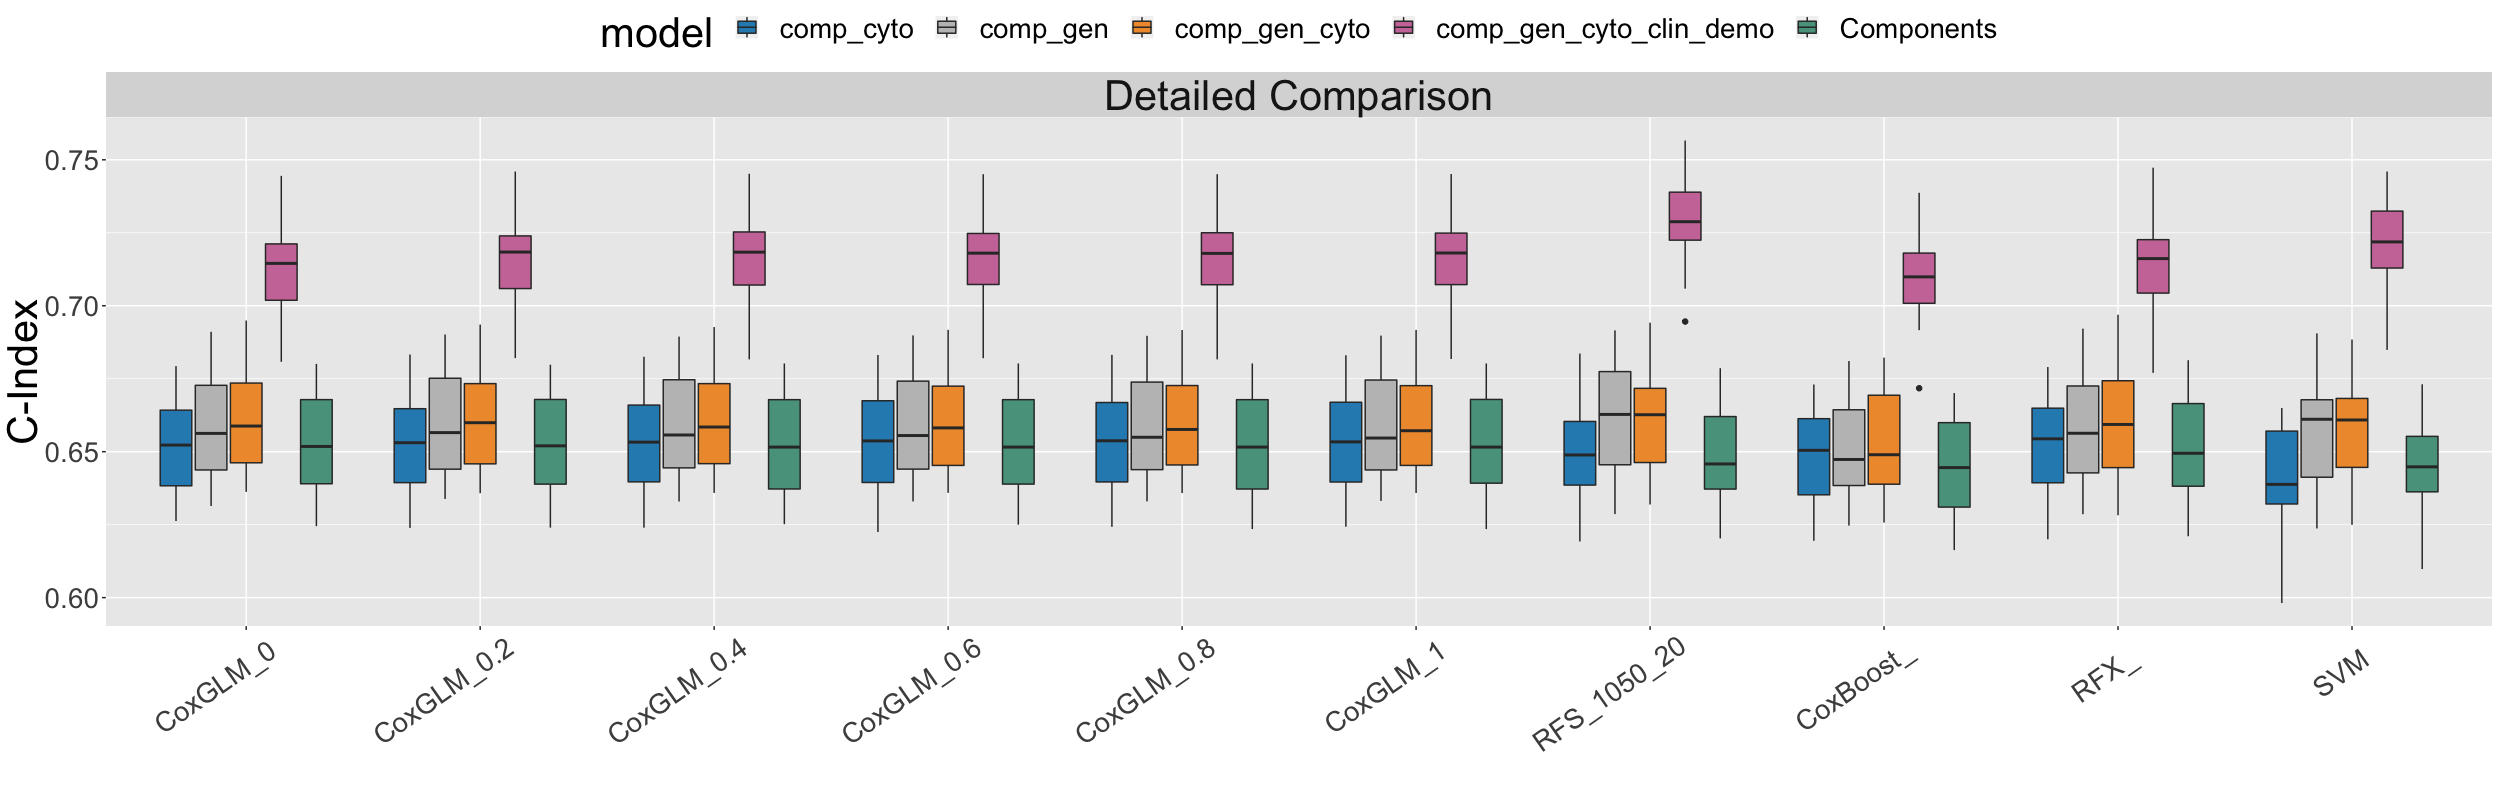

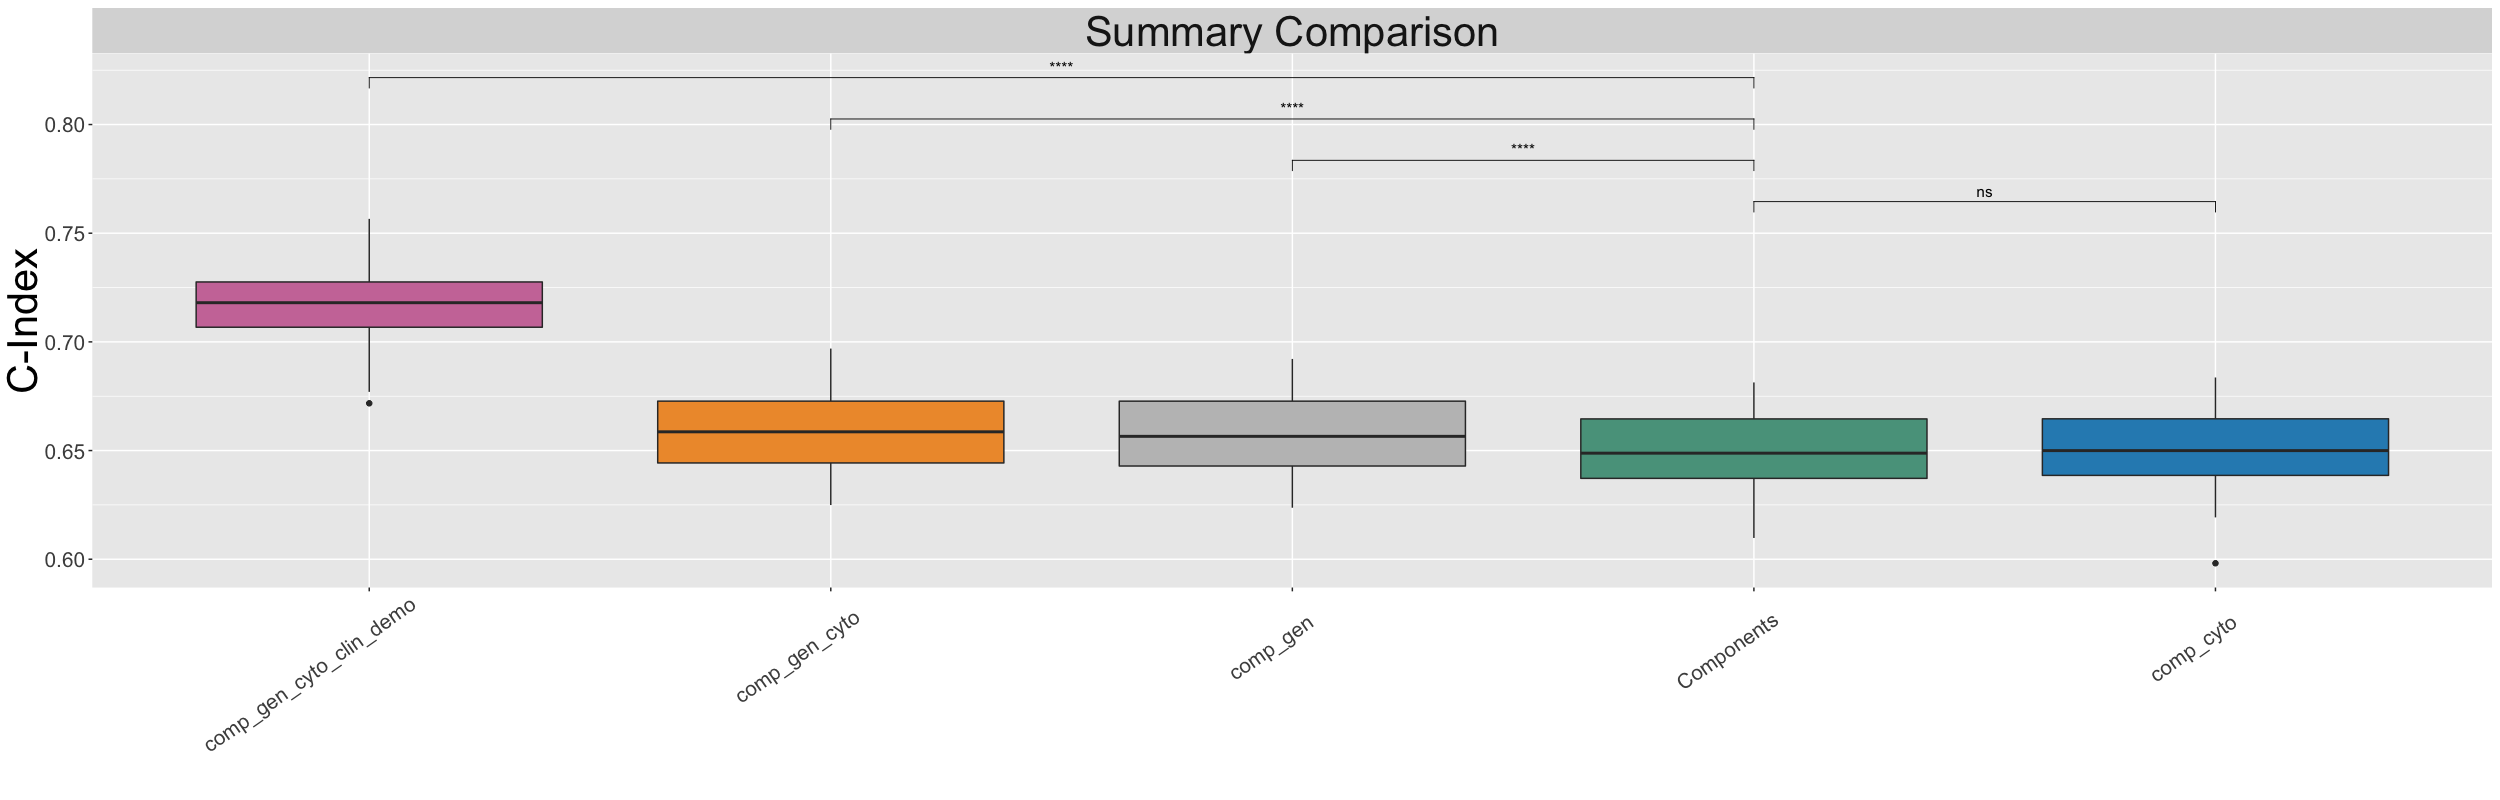

In [14]:
comparison(c("comp","comp_cyto","comp_gen","comp_gen_cyto","comp_gen_cyto_clin_demo"),tests=list(c("Components","comp_cyto"),c("Components","comp_gen"),c("Components","comp_gen_cyto"),c("Components","comp_gen_cyto_clin_demo")),
          color=c("Components"="#59A08B","comp_cyto"="#2b8cbe","comp_gen"="#BFBFBF","comp_gen_cyto"="#EE9937","comp_gen_cyto_clin_demo"="#CC79A7"),remove_RFX=F,FUN=max)

# Figure C : ELN + Comp Interaction effects

[[1]]

[[2]]


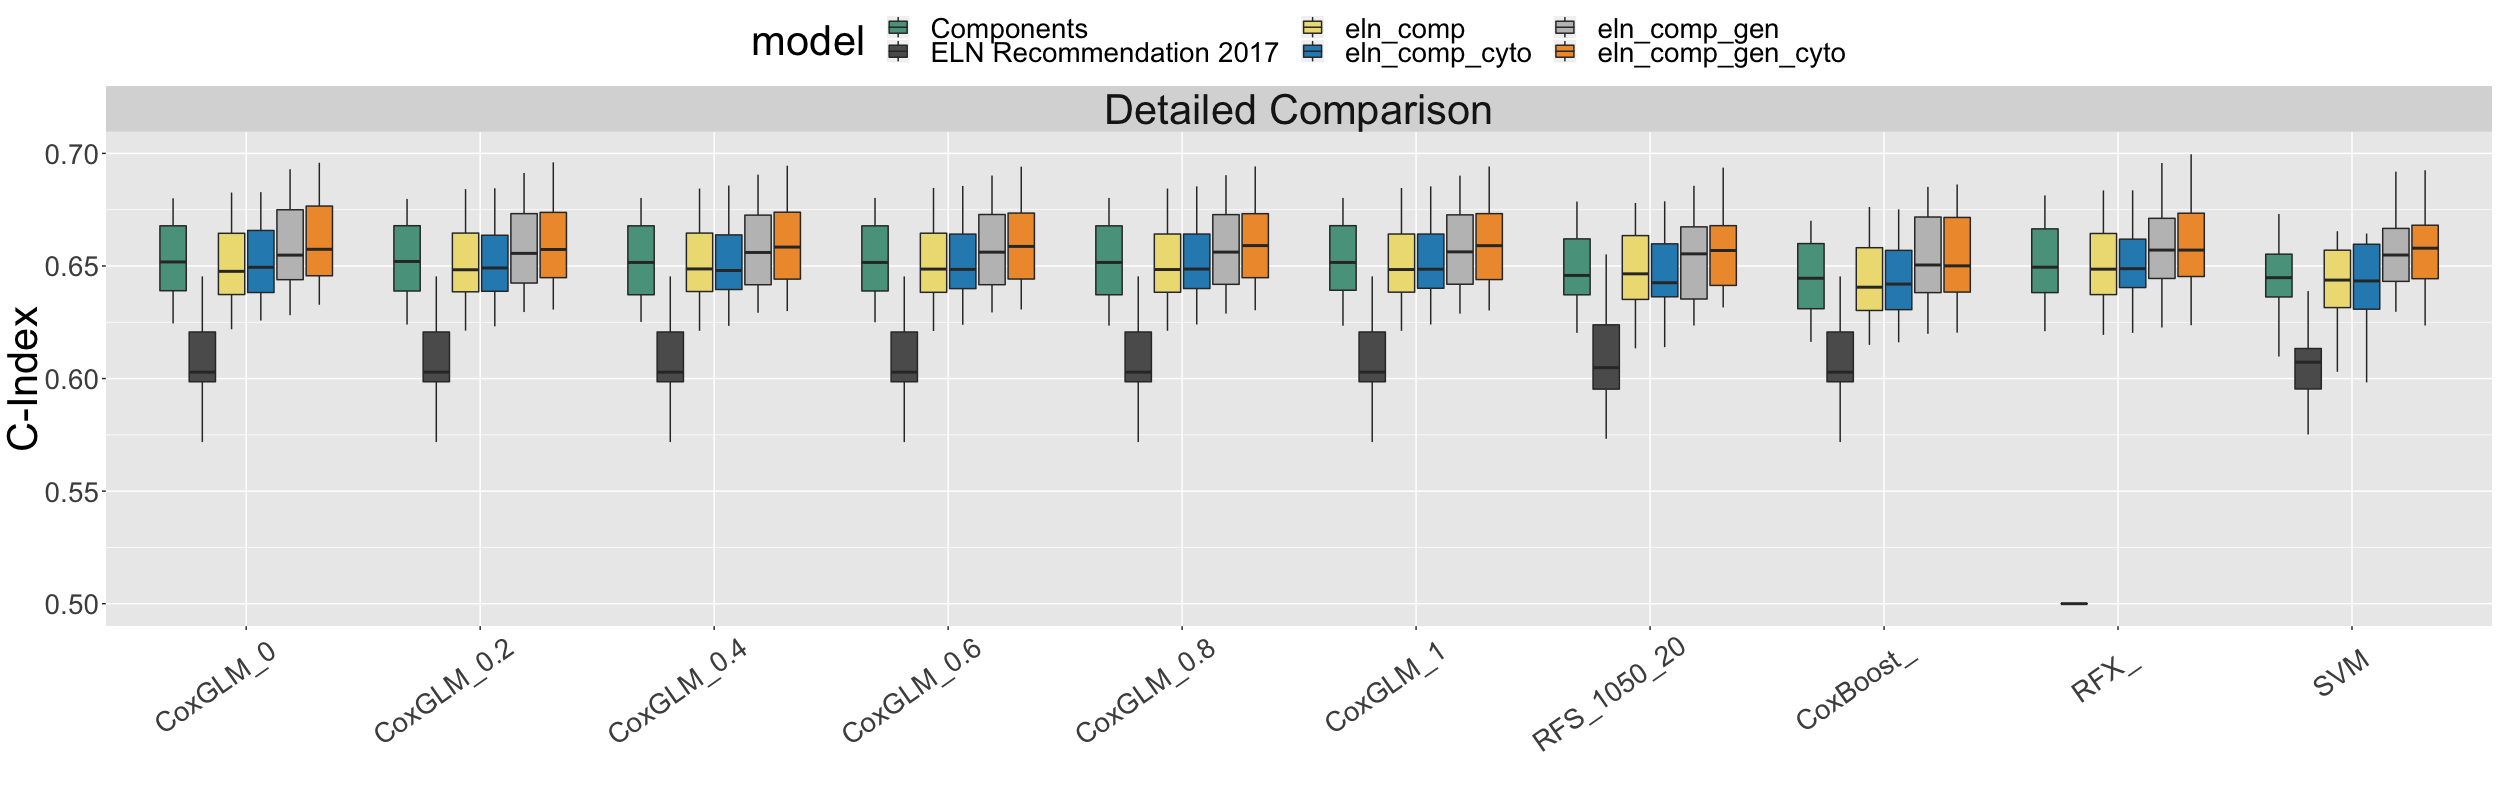

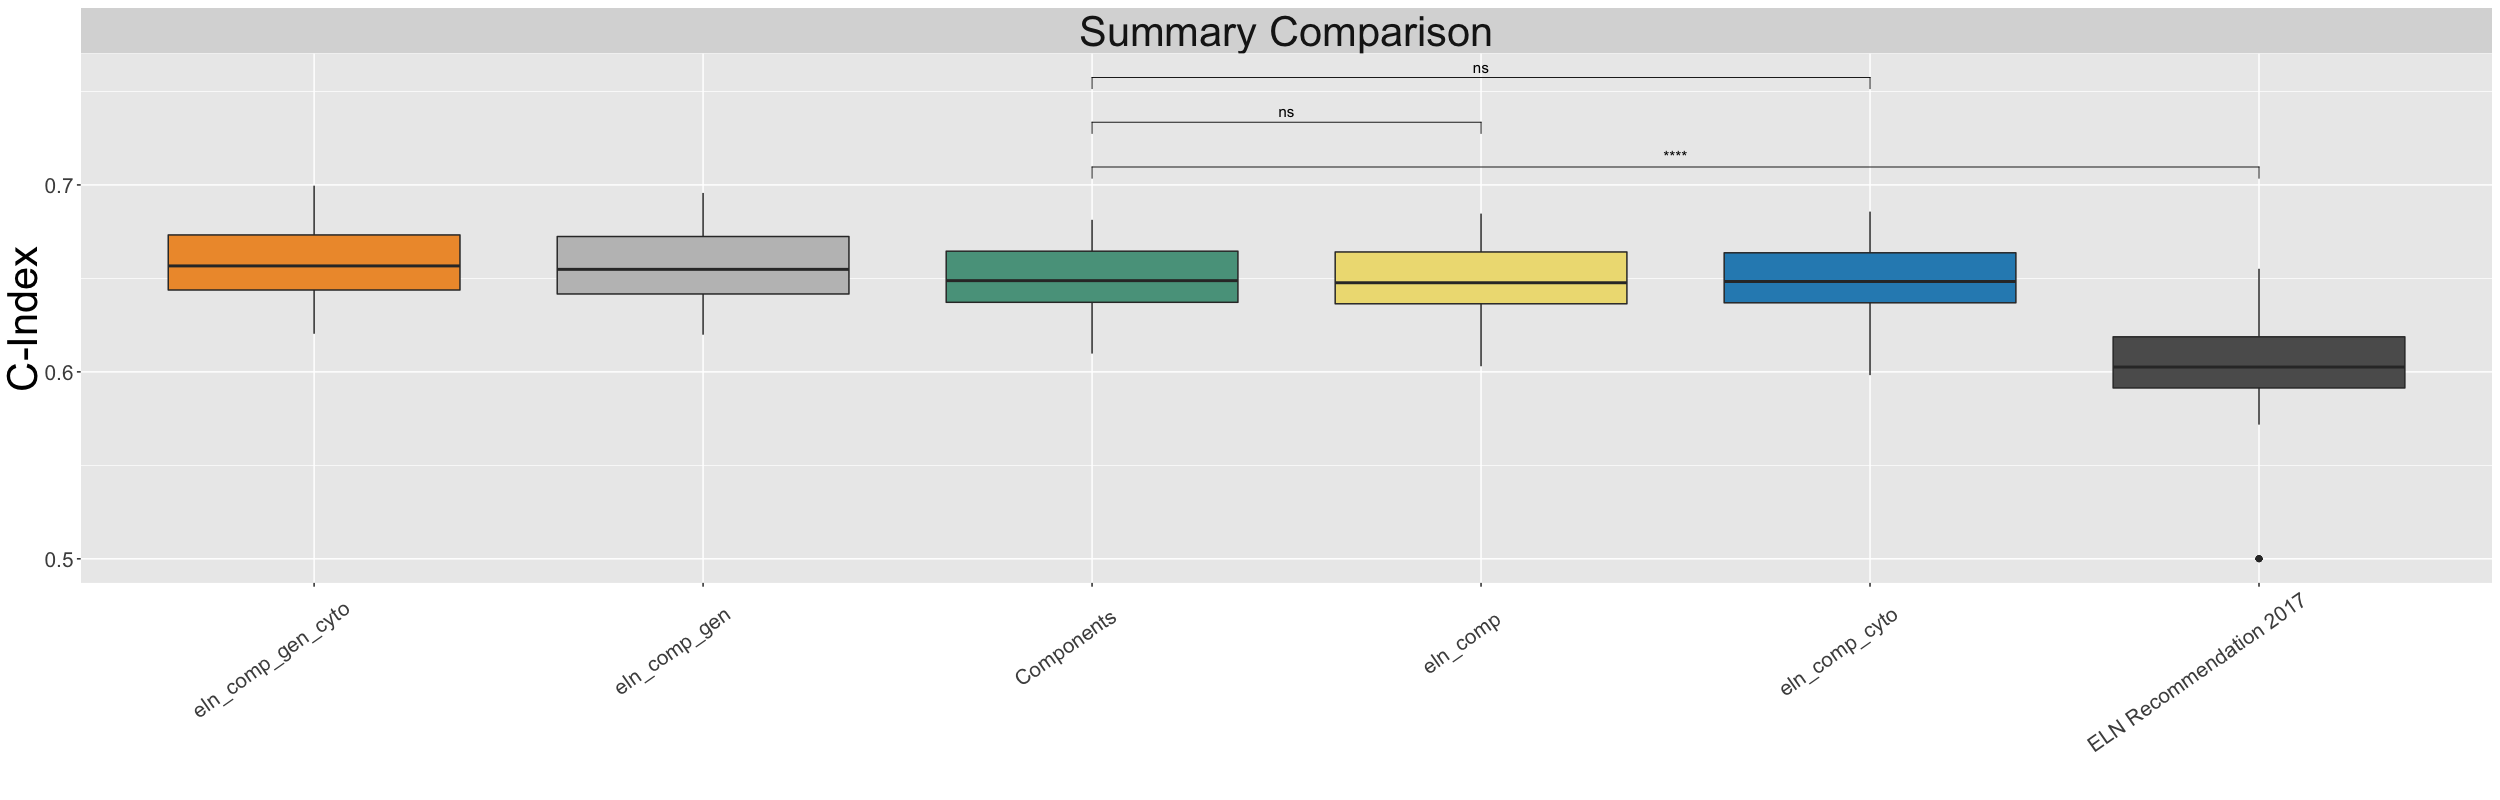

In [15]:
comparison(c("eln","comp","eln_comp","eln_comp_gen","eln_comp_cyto","eln_comp_gen_cyto"),tests=list(c("ELN Recommendation 2017","Components"),c("Components","eln_comp"),c("Components","eln_comp_cyto")),
                    color=c("ELN Recommendation 2017"="#5C5C5C","Components"="#59A08B","eln_comp"="lightgoldenrod","eln_comp_cyto"="#2b8cbe","eln_comp_gen"="#BFBFBF","eln_comp_gen_cyto"="#EE9937"),FUN=max)

# Figure D : Validation that Components capture all the eln , gen and cyto information when combined with clin demo. 
It means that the missing information is captured in clin demo.

[[1]]

[[2]]


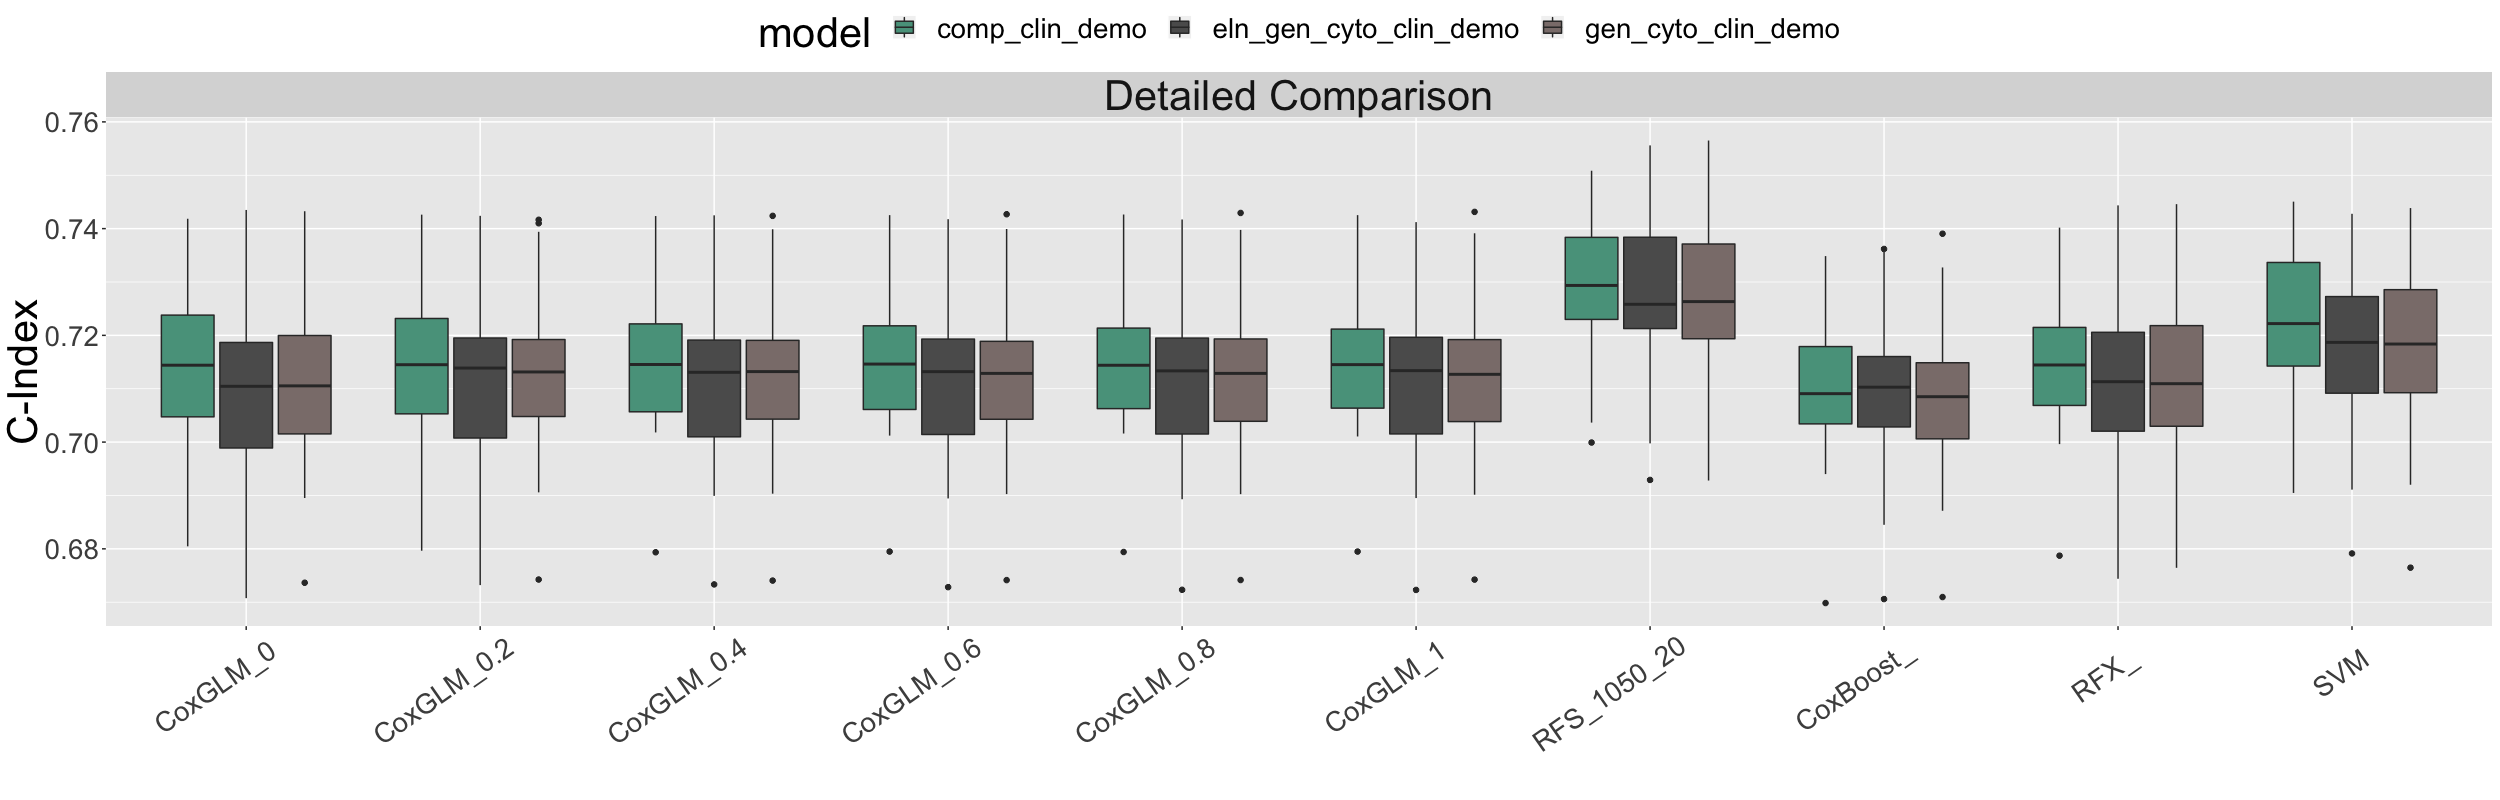

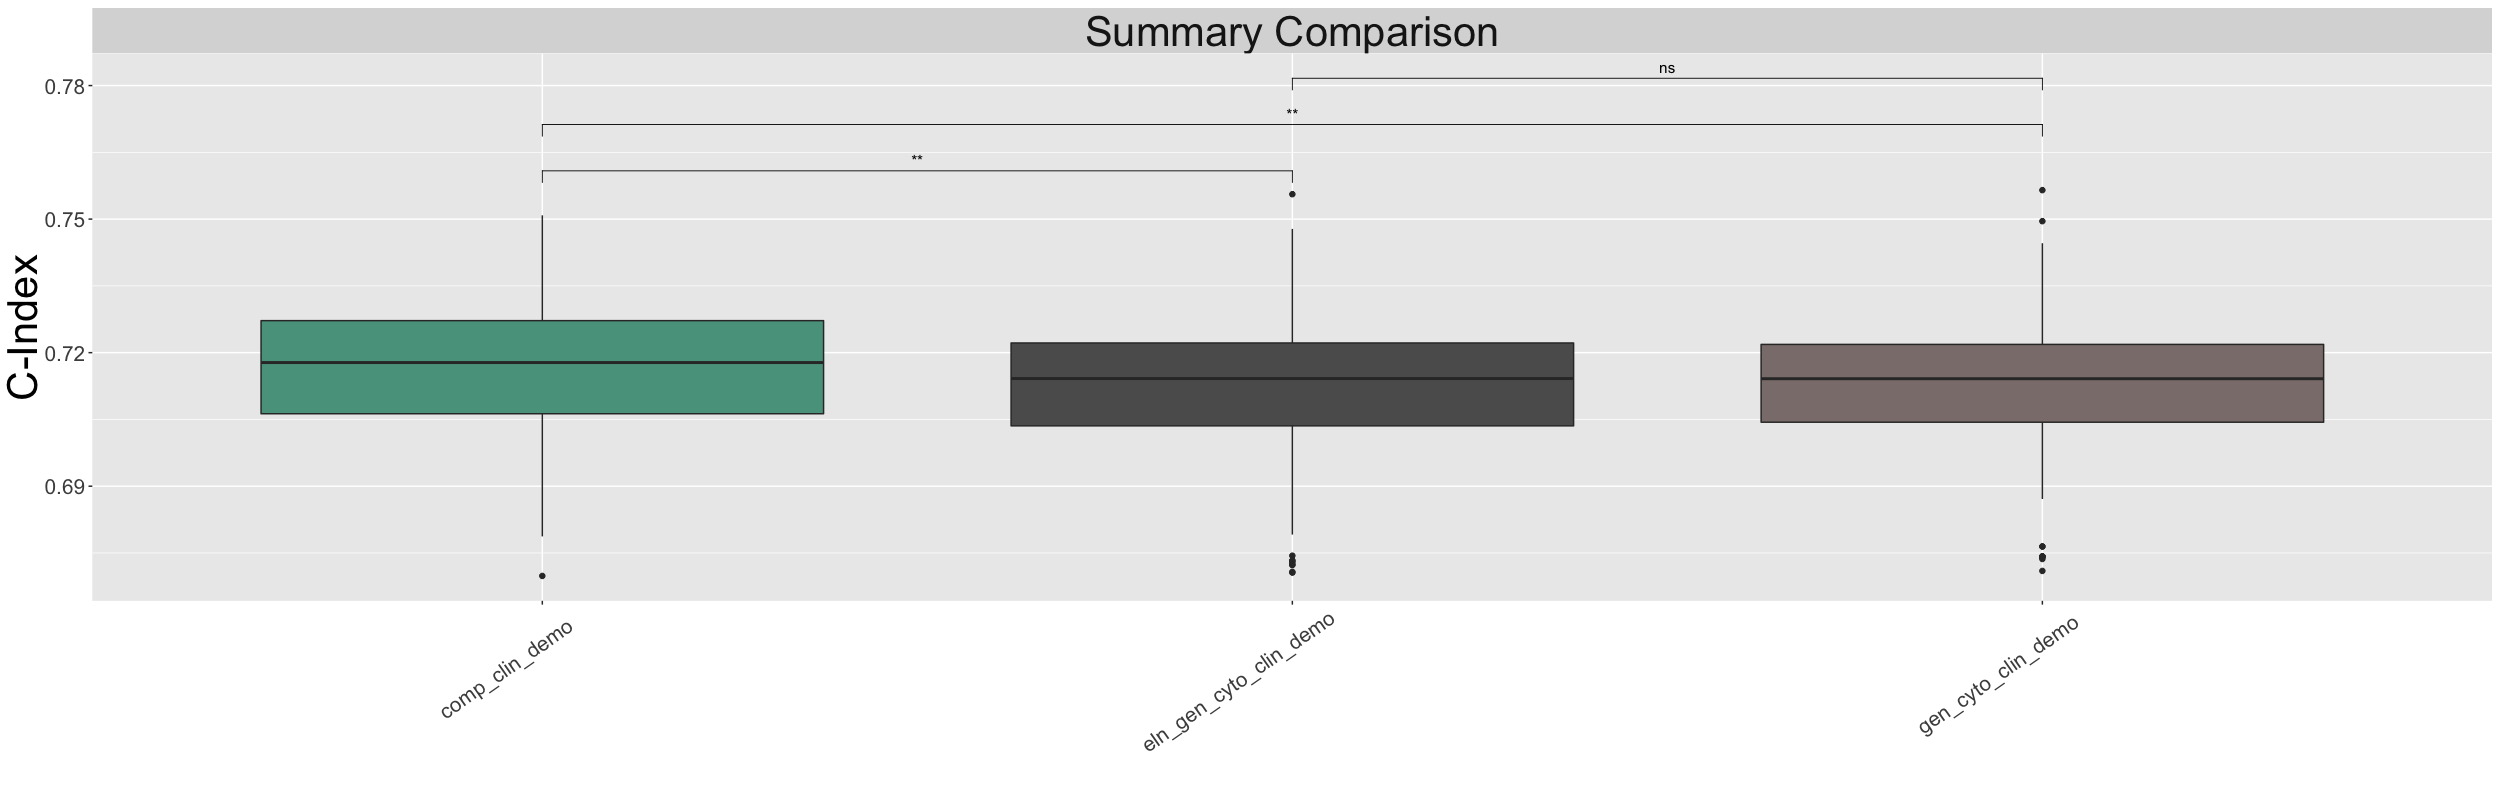

In [16]:
comparison(c("comp_clin_demo","eln_gen_cyto_clin_demo","gen_cyto_clin_demo"),tests=list(c("comp_clin_demo","eln_gen_cyto_clin_demo"),c("comp_clin_demo","gen_cyto_clin_demo"),c("gen_cyto_clin_demo","eln_gen_cyto_clin_demo")),
                    color=c("comp_clin_demo"="#59A08B","eln_gen_cyto_clin_demo"="#5C5C5C","gen_cyto_clin_demo"="mistyrose4"))

# FIGURE E : Impact on C-I of the different correlates

In [21]:
comparison(c("gen","cyto","clin","demo","gen_cyto","gen_cyto_clin_demo","cyto_gen_demo","comp","eln"),tests=list(c("gen","cyto"),c("gen","gen_cyto"),c("cyto","gen_cyto"),c("gen_cyto","cyto_gen_demo"),c("cyto_gen_demo","gen_cyto_clin_demo"),c("Components","gen_cyto")),
          color=c("ELN Recommendation 2017"="#5C5C5C","Components"="#59A08B","gen"="#BFBFBF","gen_cyto"="#EE9937","gen_cyto_clin_demo"="mistyrose4","cyto"="#2b8cbe","clin"="#870C14","demo"="#a6bddb","cyto_gen_demo"="lightgoldenrod"))

ERROR: Error in file(file, "rt"): cannot open the connection


# I) Comparisons for ELN VS Components

## 1) Added Value of genetic,cytogenetic and Components on ELN

[[1]]

[[2]]


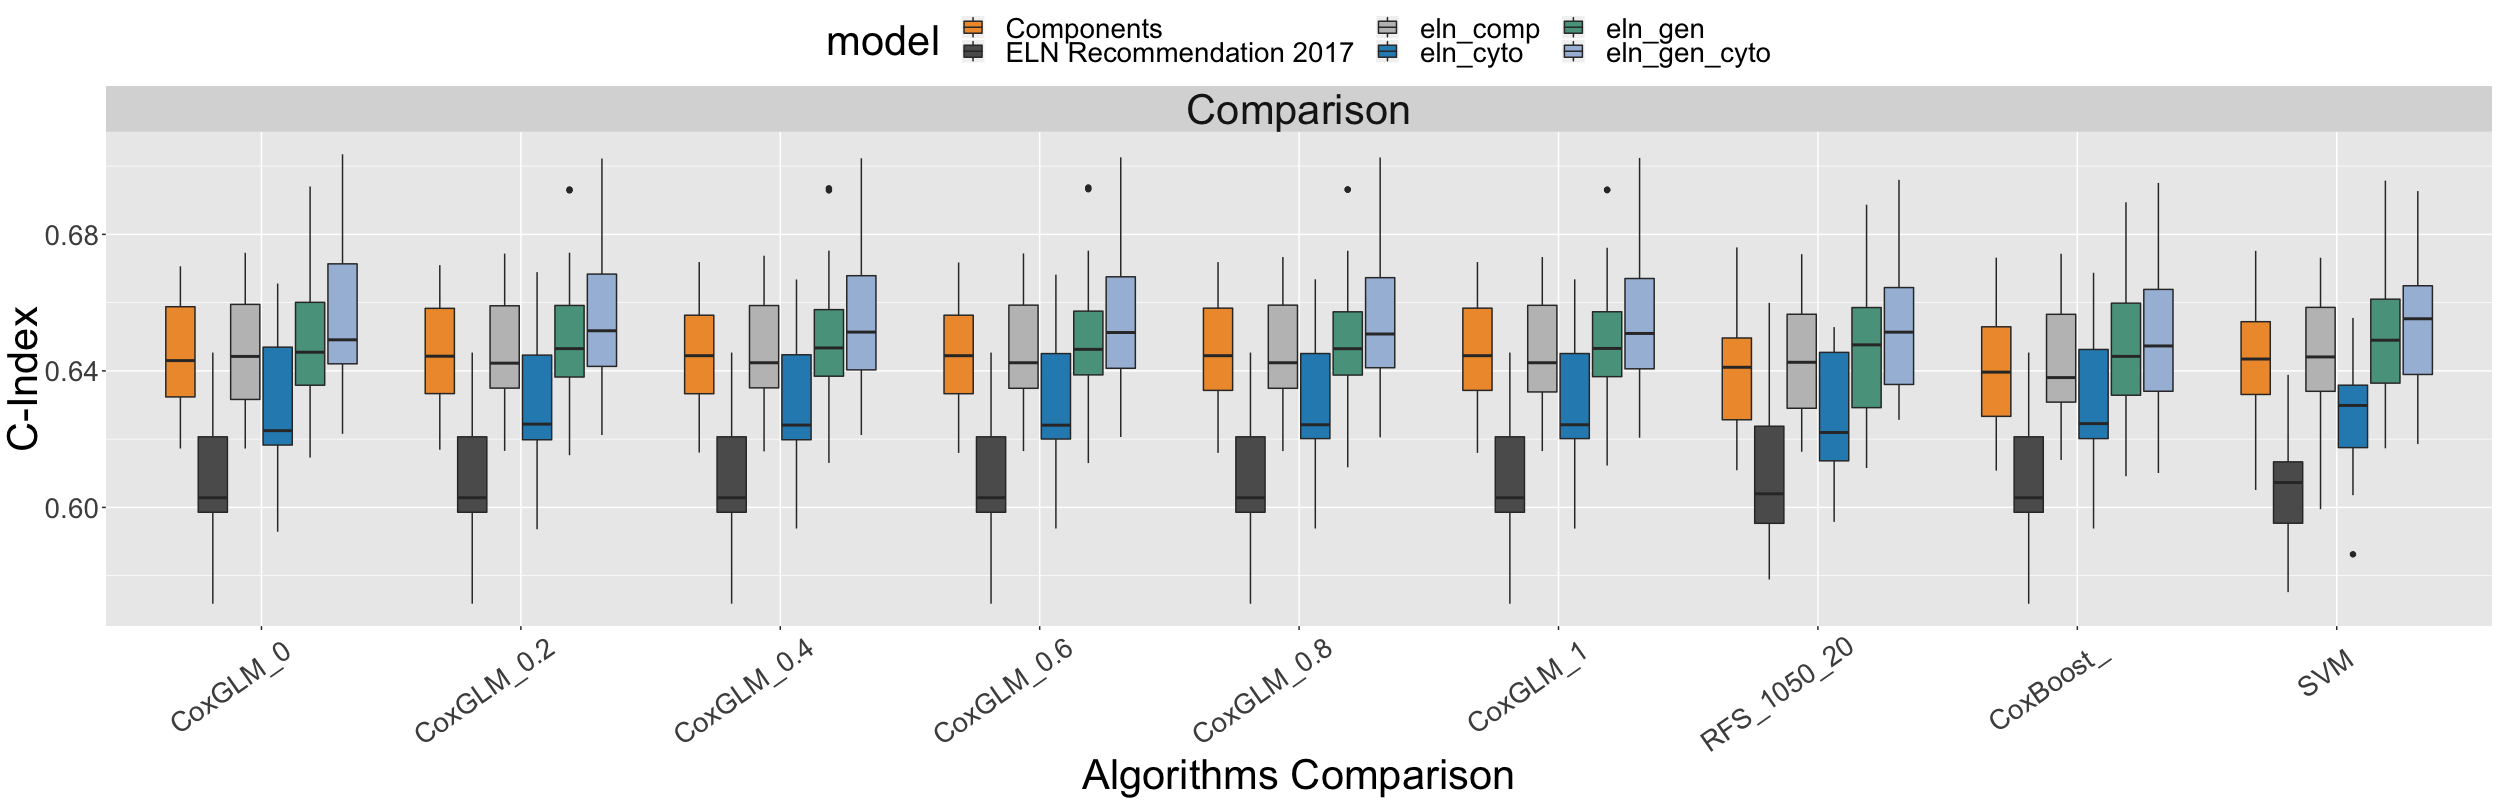

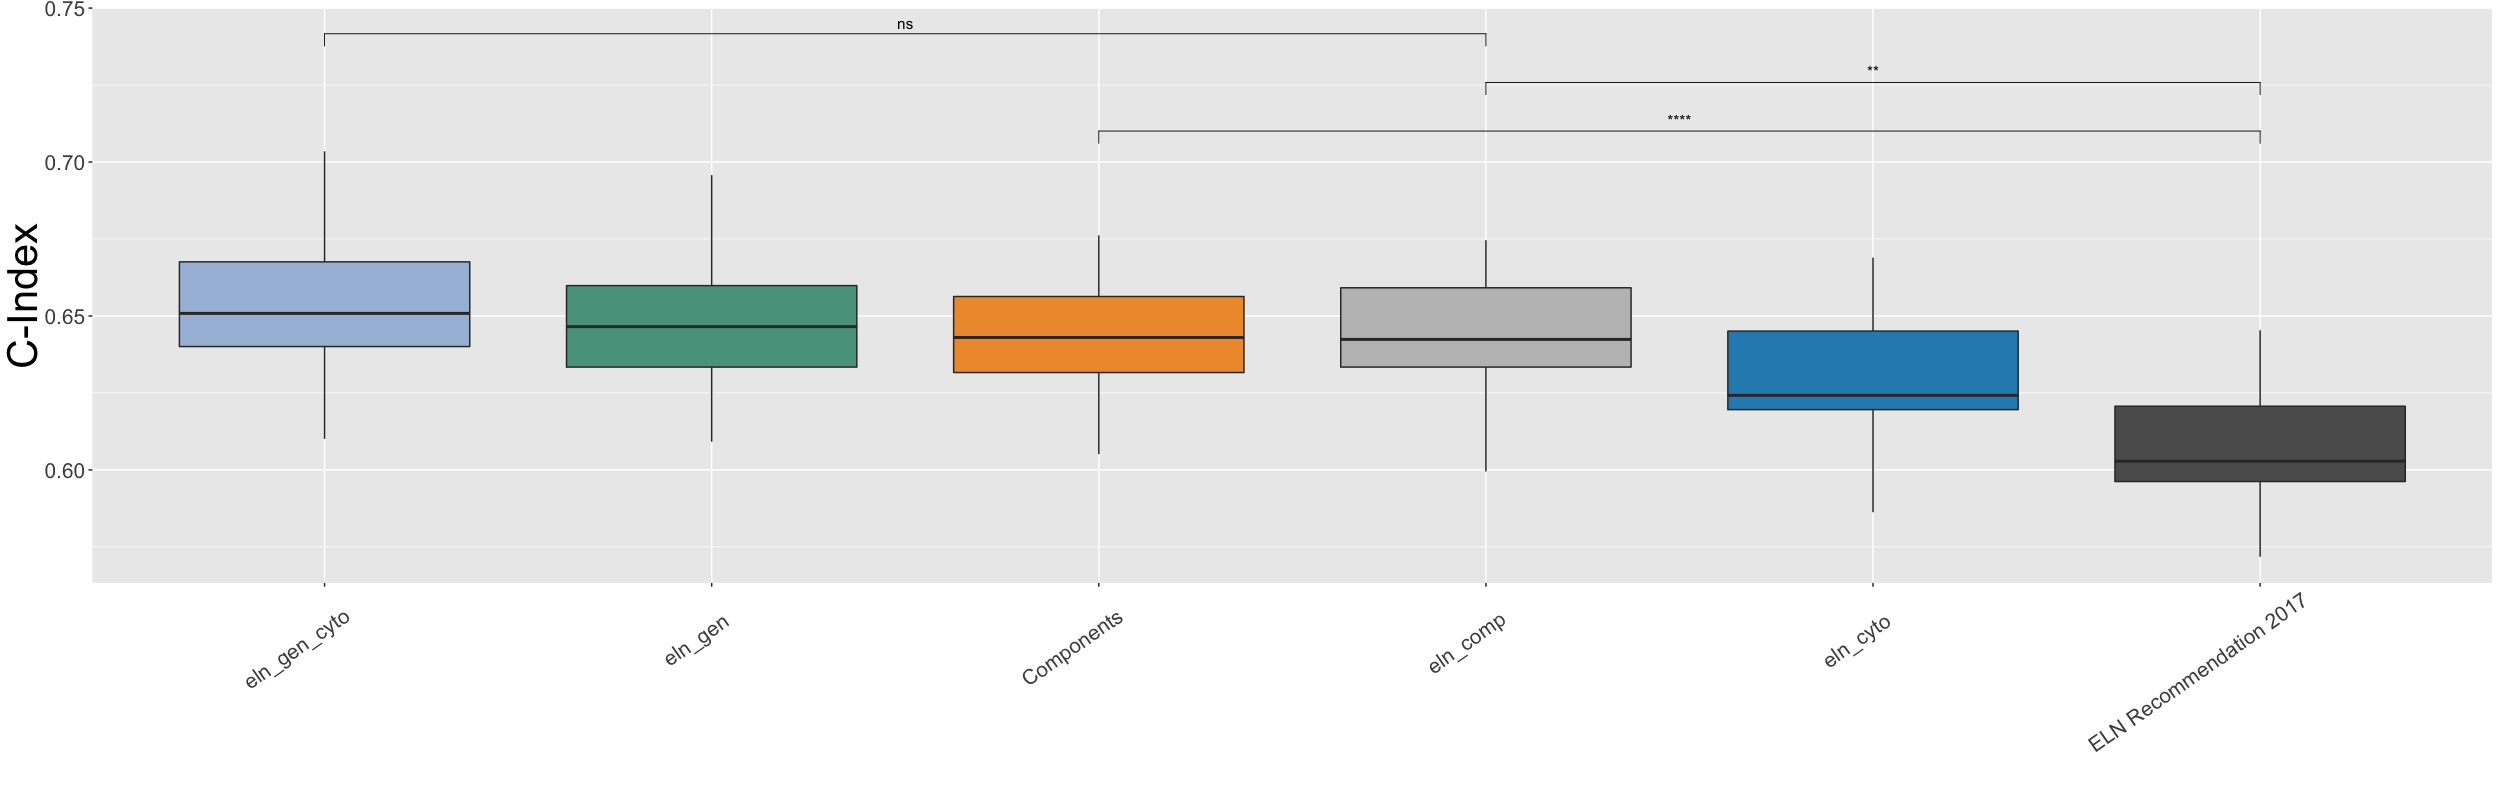

In [194]:
comparison(c("eln","eln_comp","eln_gen","eln_cyto","eln_gen_cyto","comp"),tests=list(c("ELN Recommendation 2017","Components"),c("ELN Recommendation 2017","eln_comp"),c("eln_comp","eln_gen_cyto")))

[[1]]

[[2]]


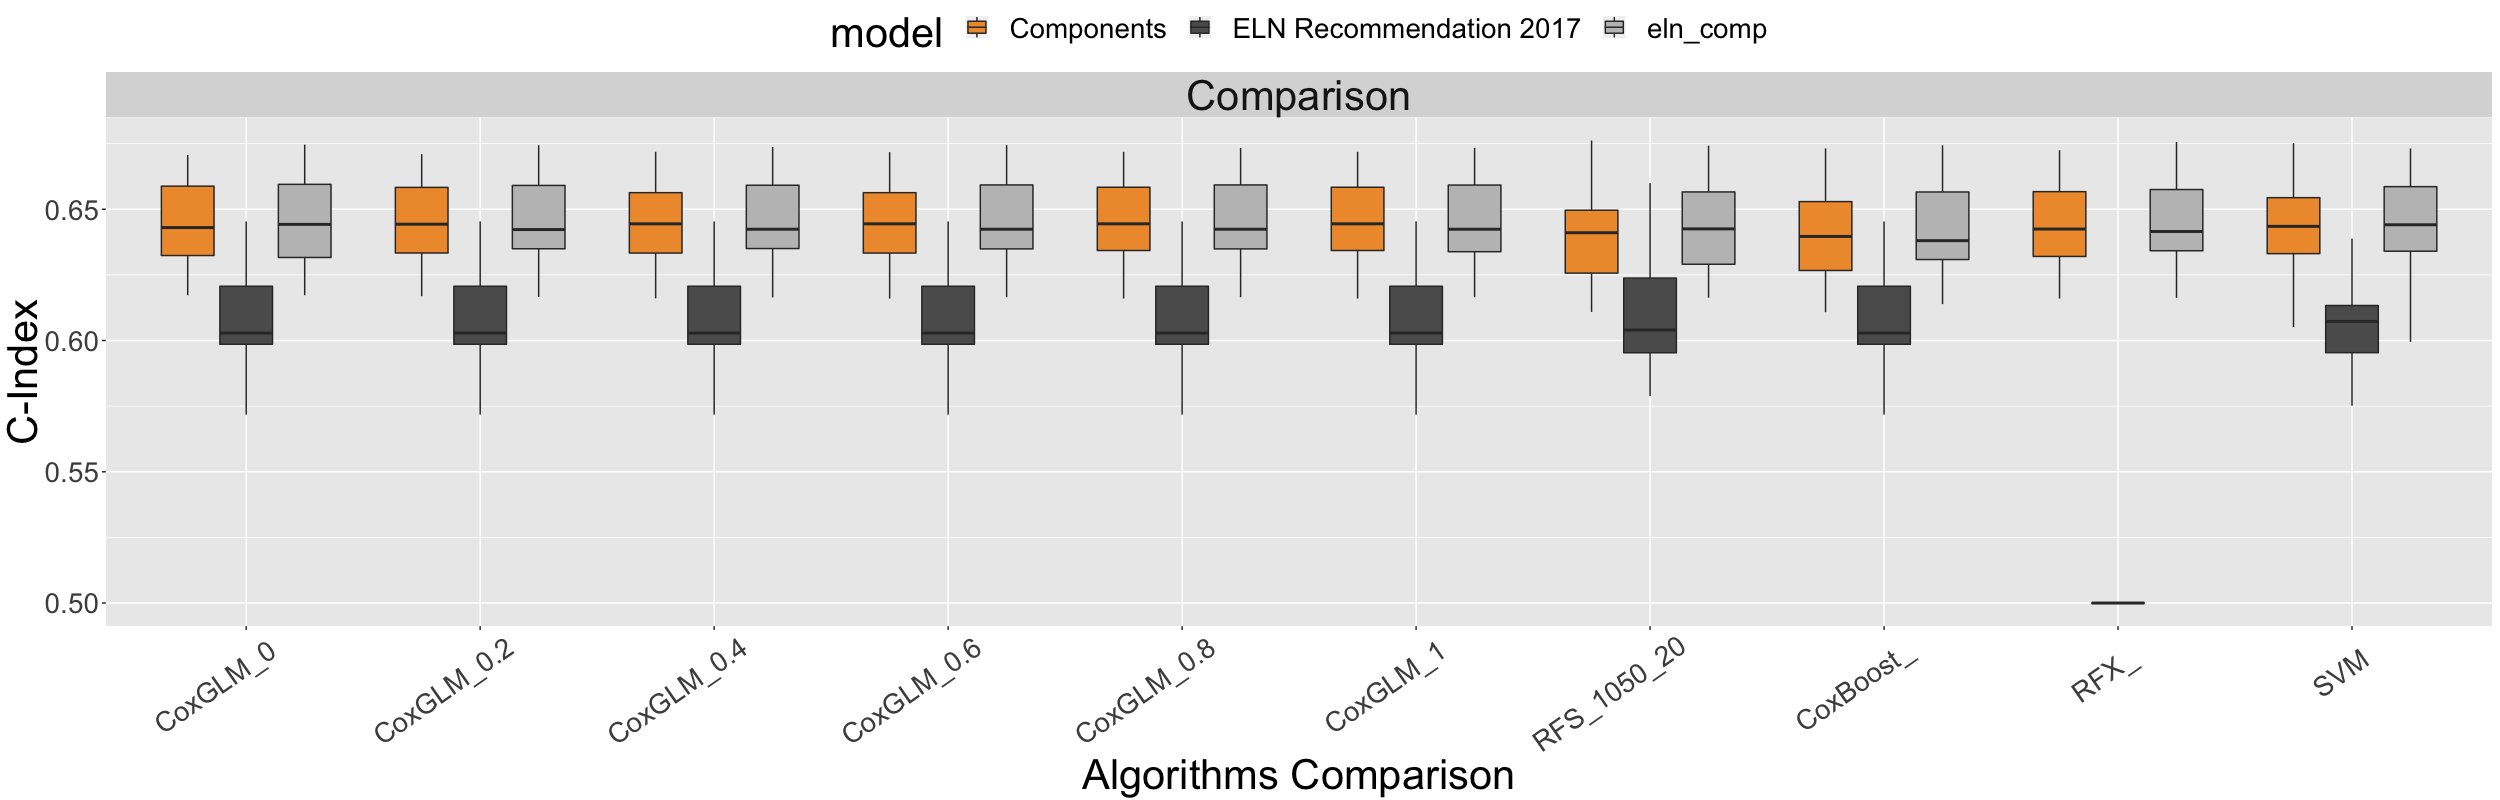

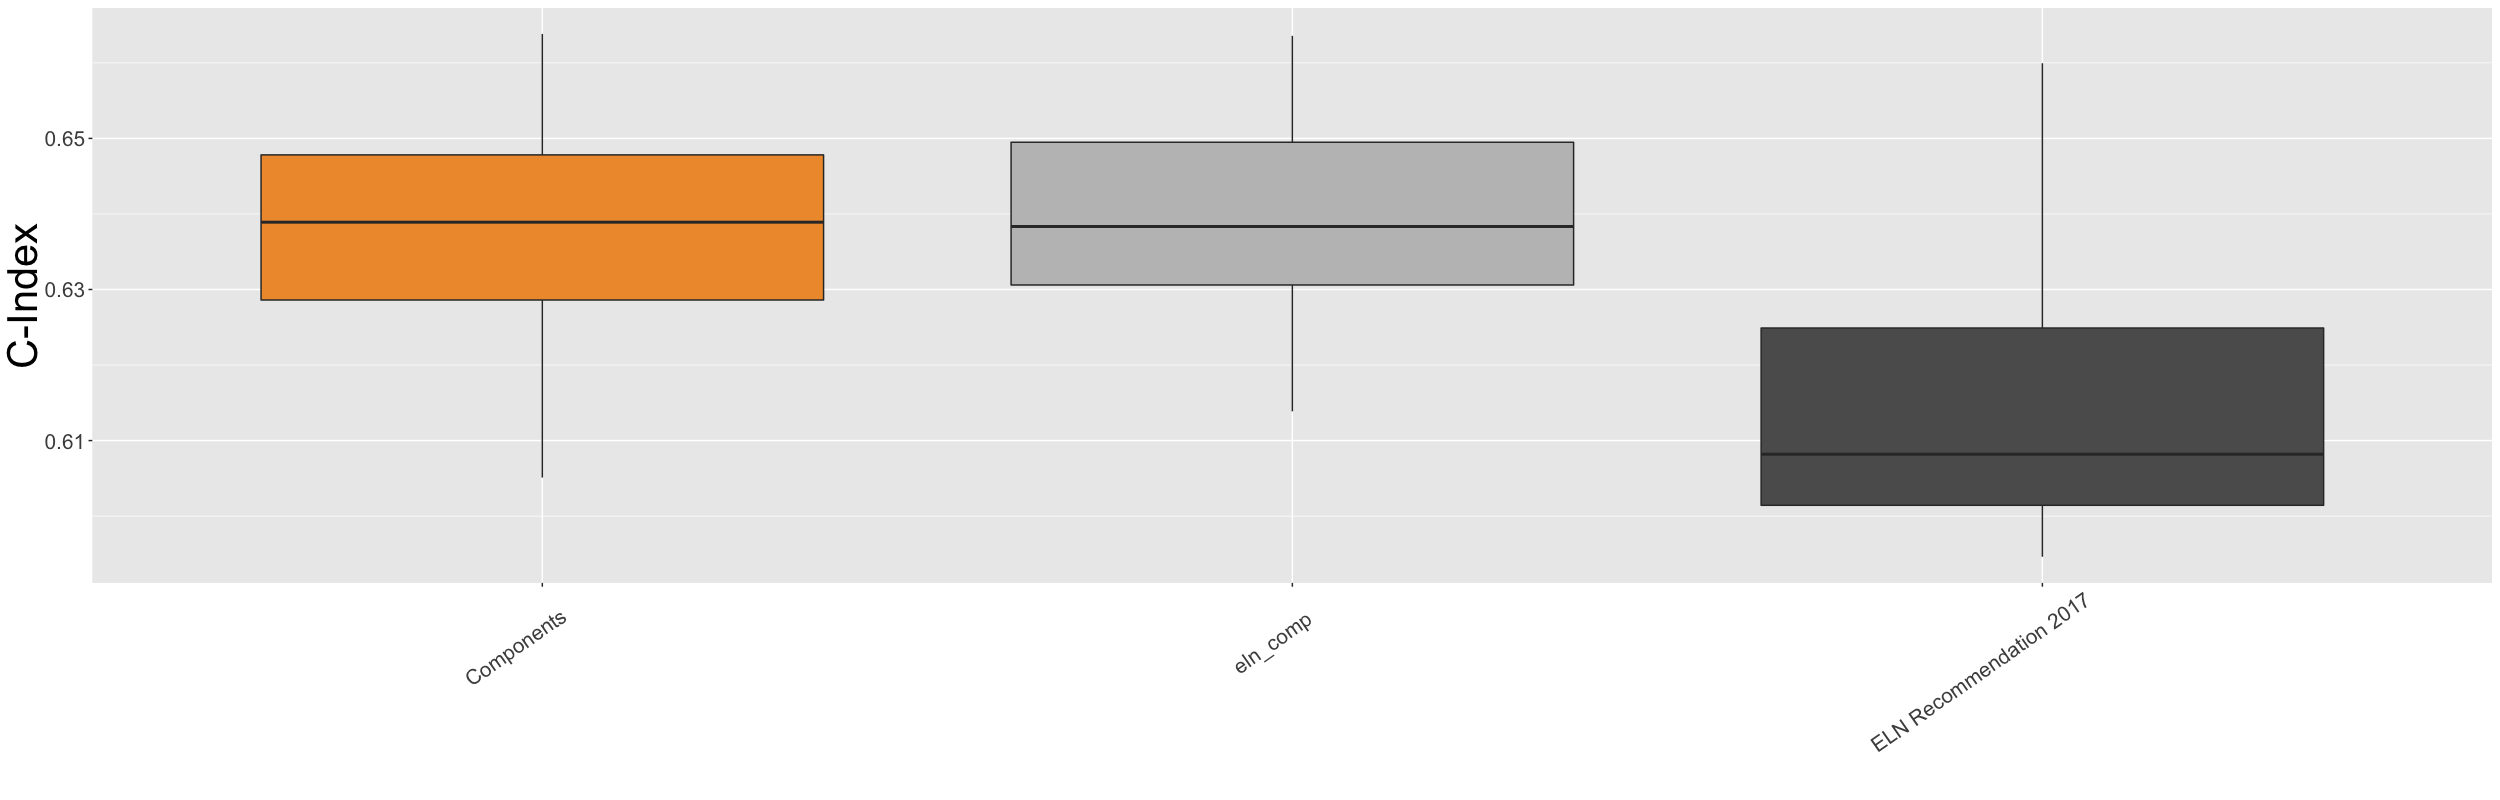

In [164]:
comparison(c("eln","eln_comp","comp"),tests=list(c("ELN Recommendation 2017","Components"),c("ELN Recommendation 2017","eln_comp"),c("eln_comp","Components")))

### Huge benefit of adding components to eln! But adding gen and cyto does not bring much to eln compared to components.
### Let's show that Components are capturing cyto and genetic information by comparing the models :
In components, it means that we still miss a bit of genetic info but not much compare to ELN and we already capture all cyto info

#### Motivation to refine ELN with Components : ELN + Components capture more information than GEN + CYTO

ELN is not capturing all cyto info (graph above)
(Components are capturing all cyto info graph below)

[[1]]

[[2]]


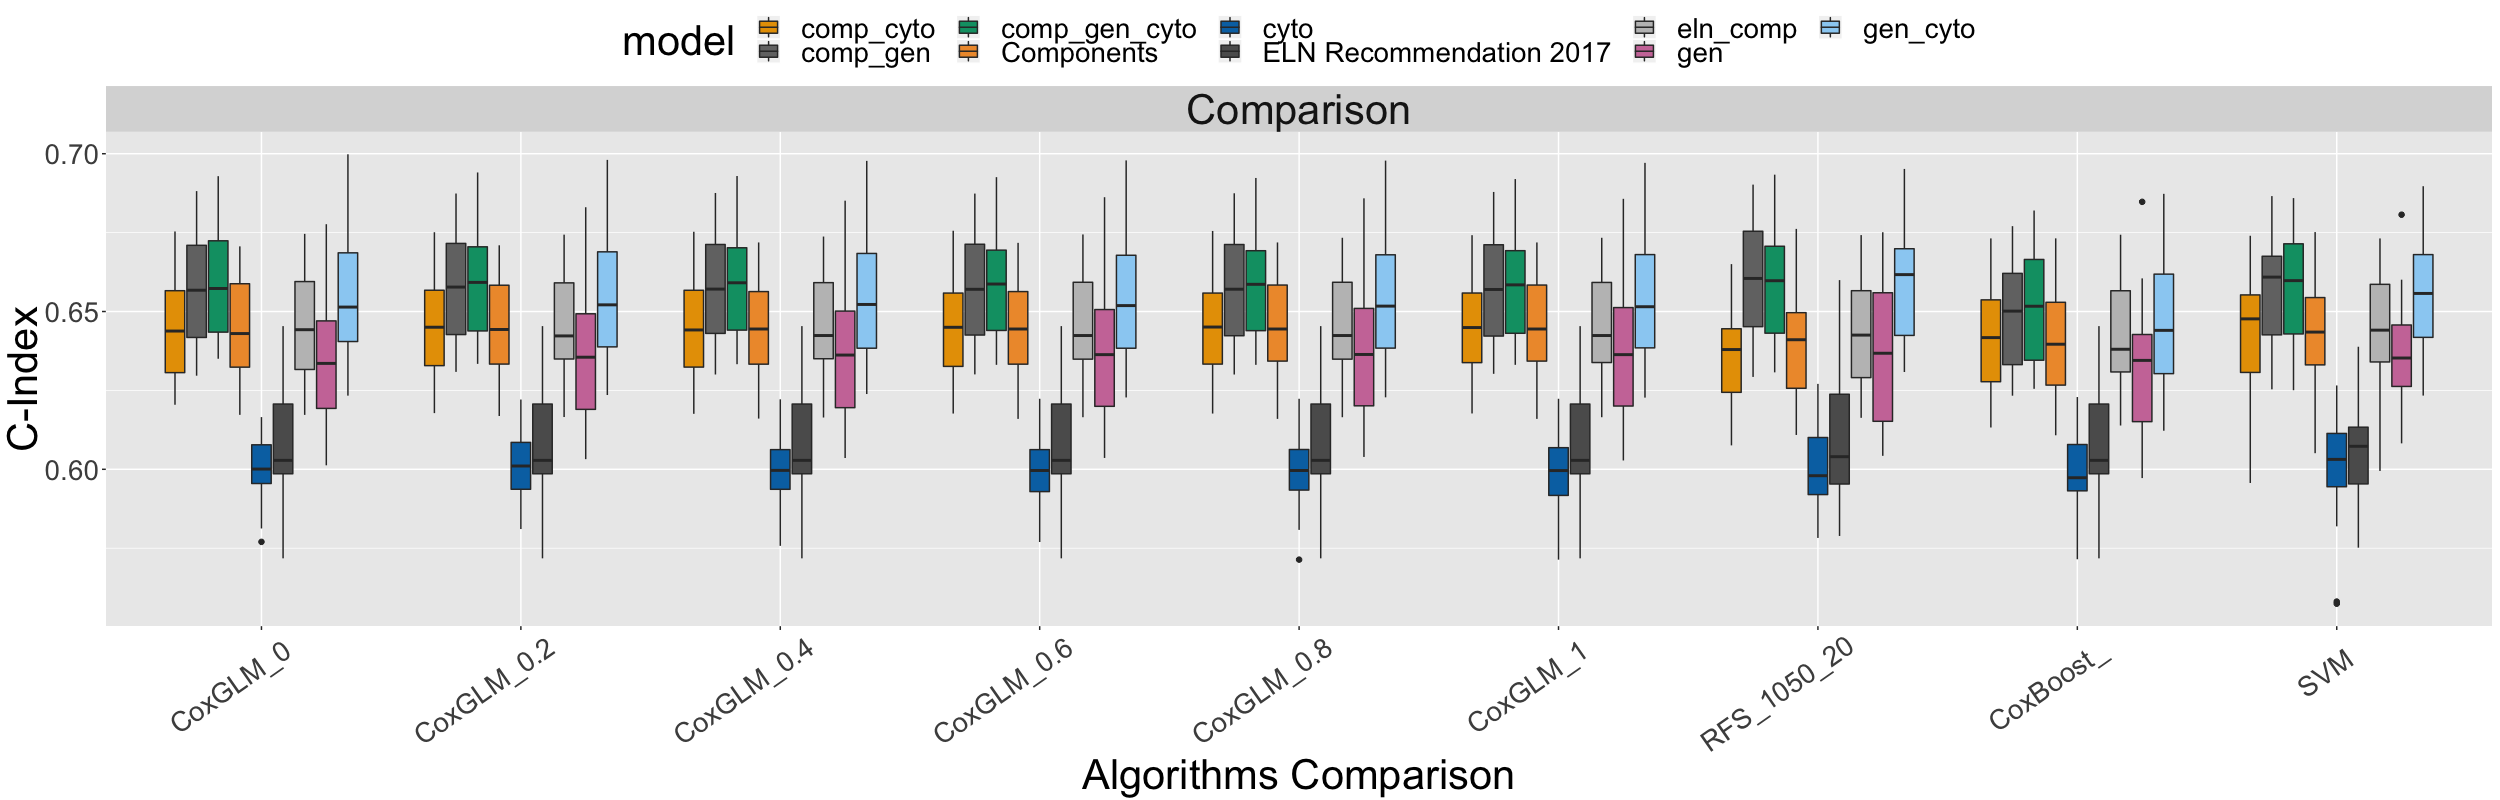

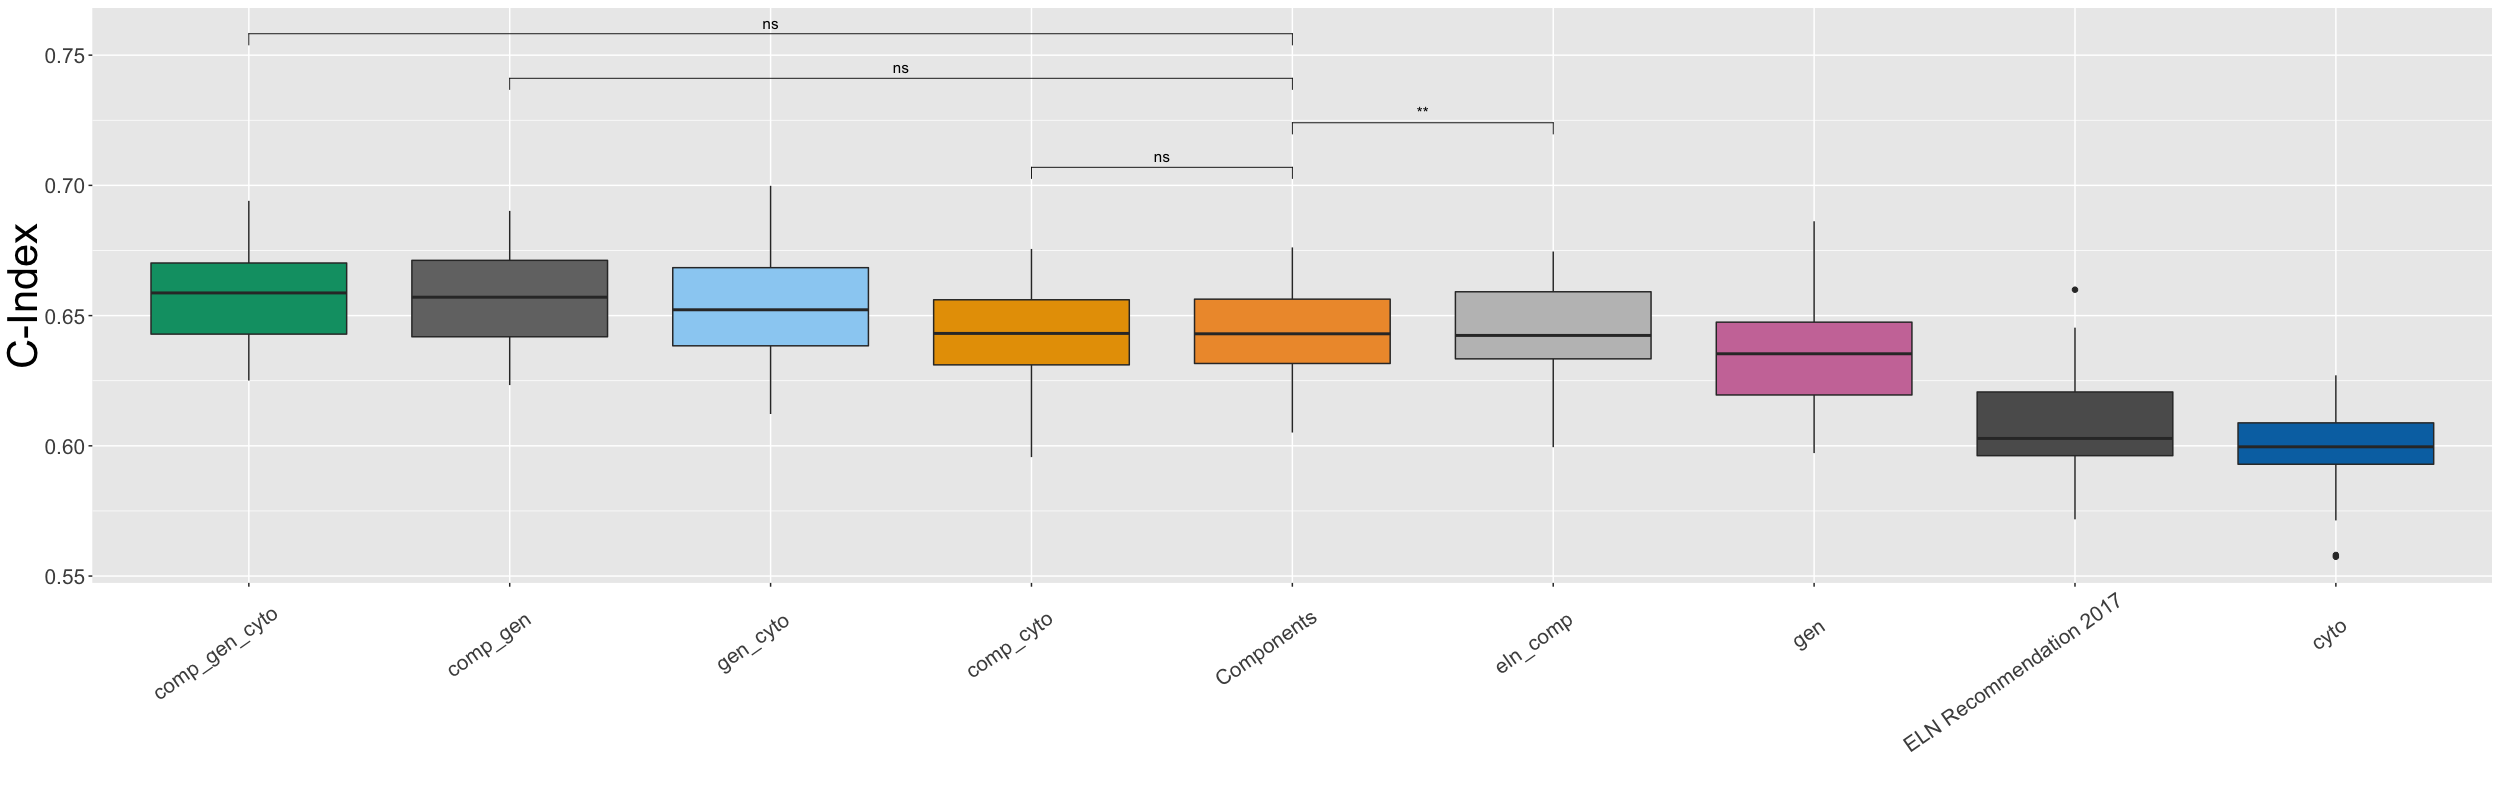

In [185]:
comparison(c("comp","eln","gen","cyto","gen_cyto","comp_gen","comp_cyto","comp_gen_cyto","eln_comp"),tests=list(c("Components","comp_cyto"),c("Components","eln_comp"),c("Components","comp_gen"),c("Components","comp_gen_cyto")))

## 2) Added Value of clinical and demographical features to ELN and then to Components

#### ELN and Components follow the same trend with regard to Clin and Demo : Basically because they do not capture any of the information from clinical and demo

[[1]]

[[2]]


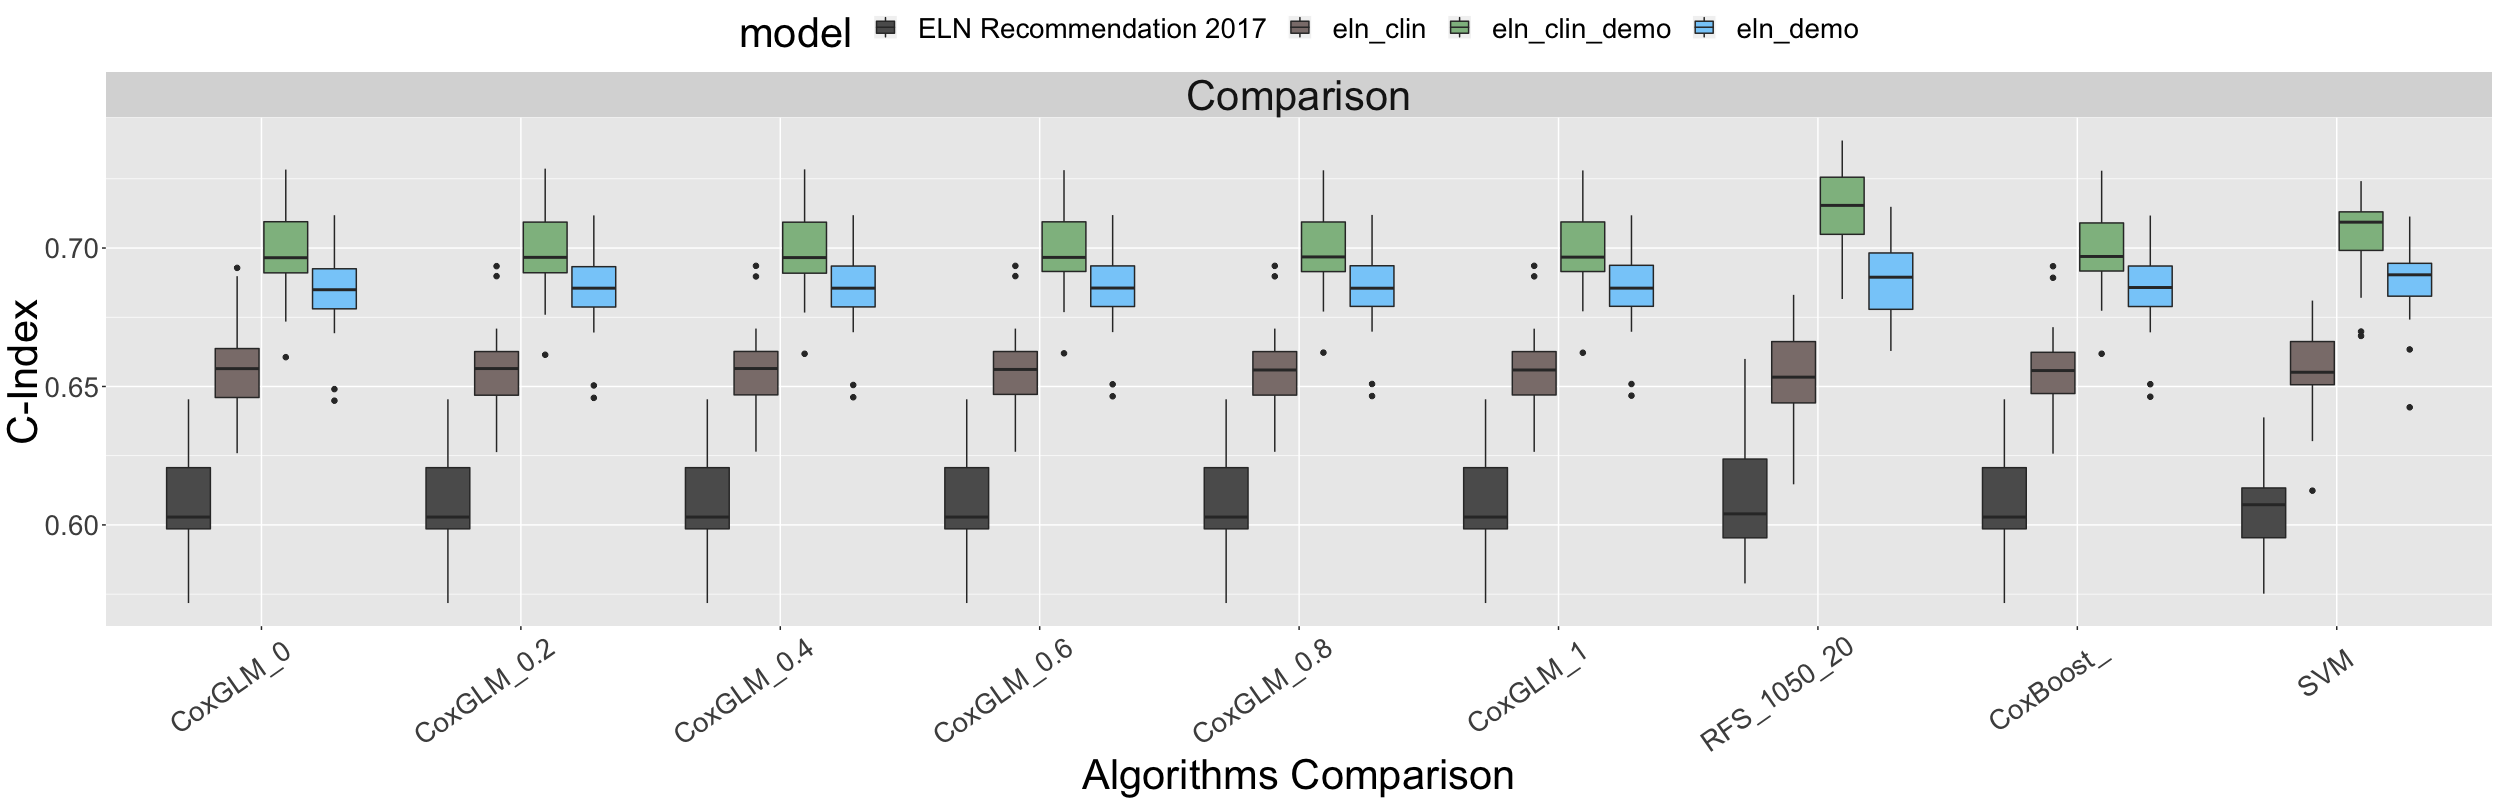

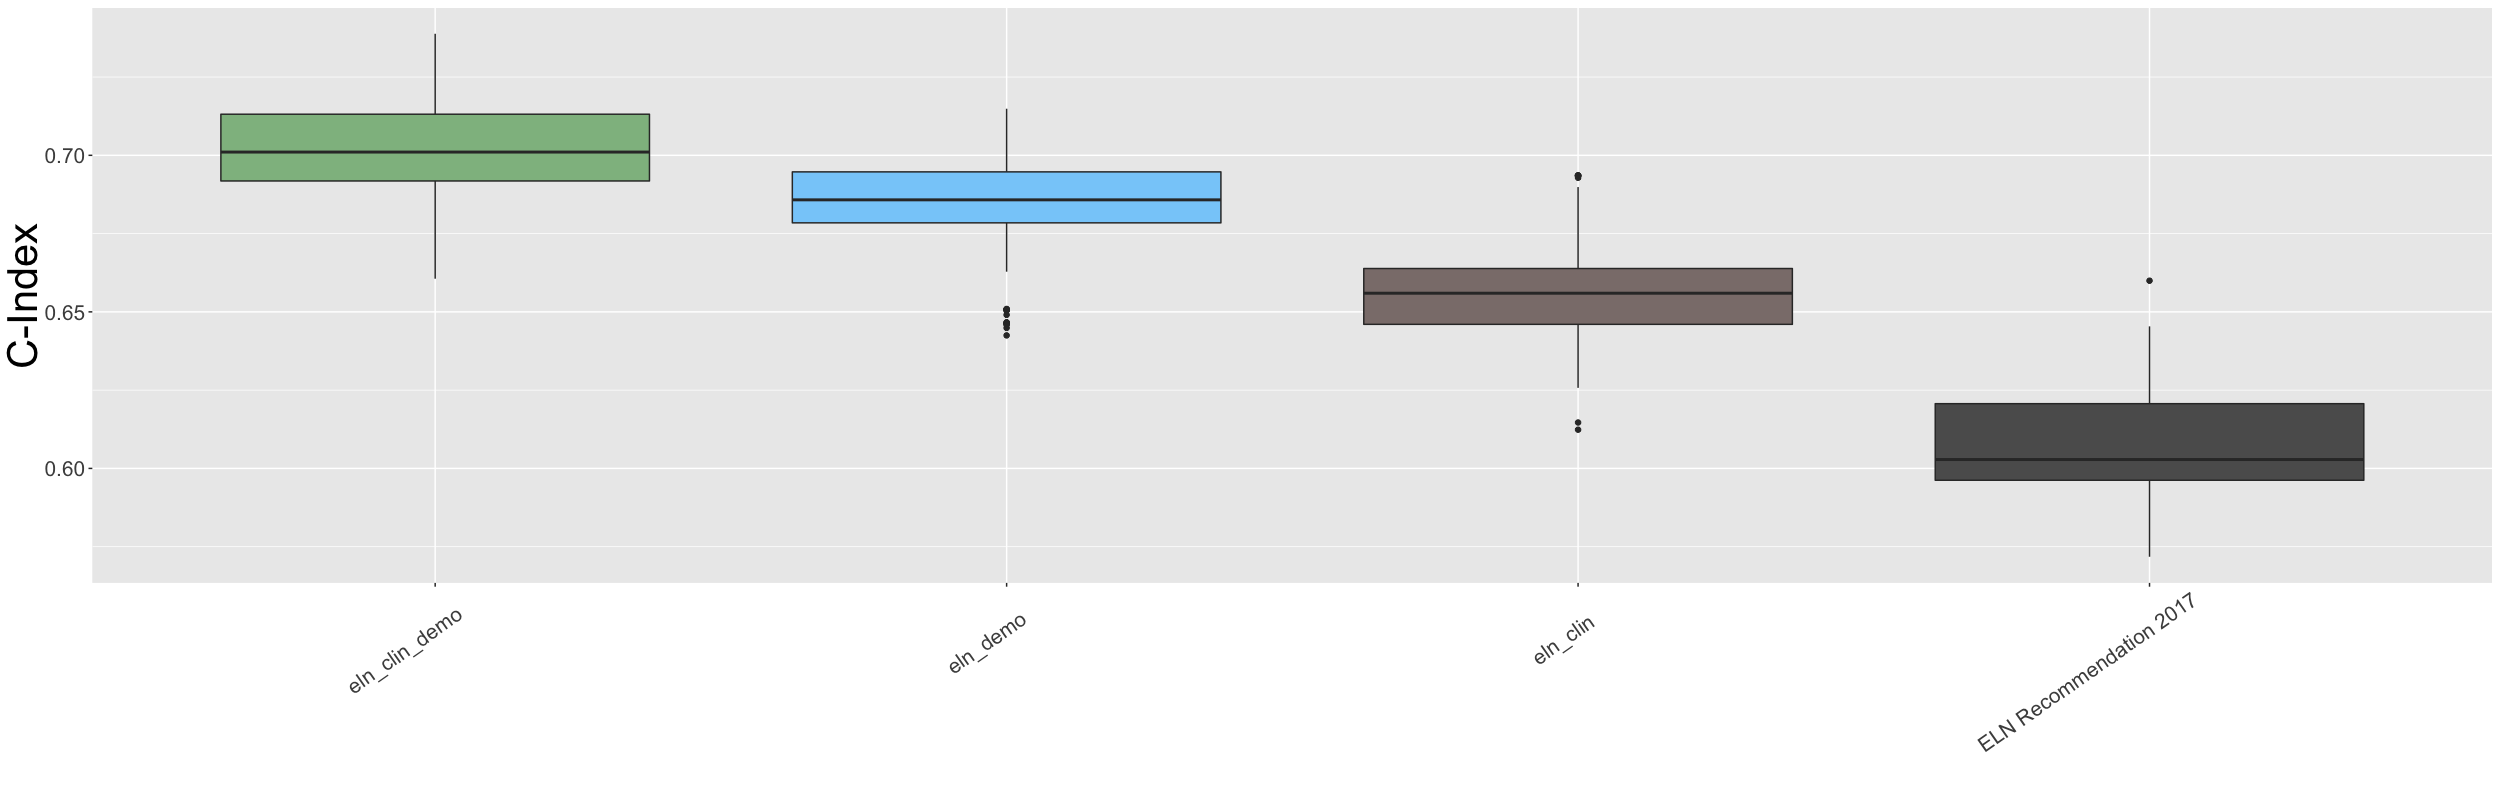

In [60]:
comparison(c("eln","eln_demo","eln_clin","eln_clin_demo"))

# 3) Added value of Clin and Demo to Components

[[1]]

[[2]]


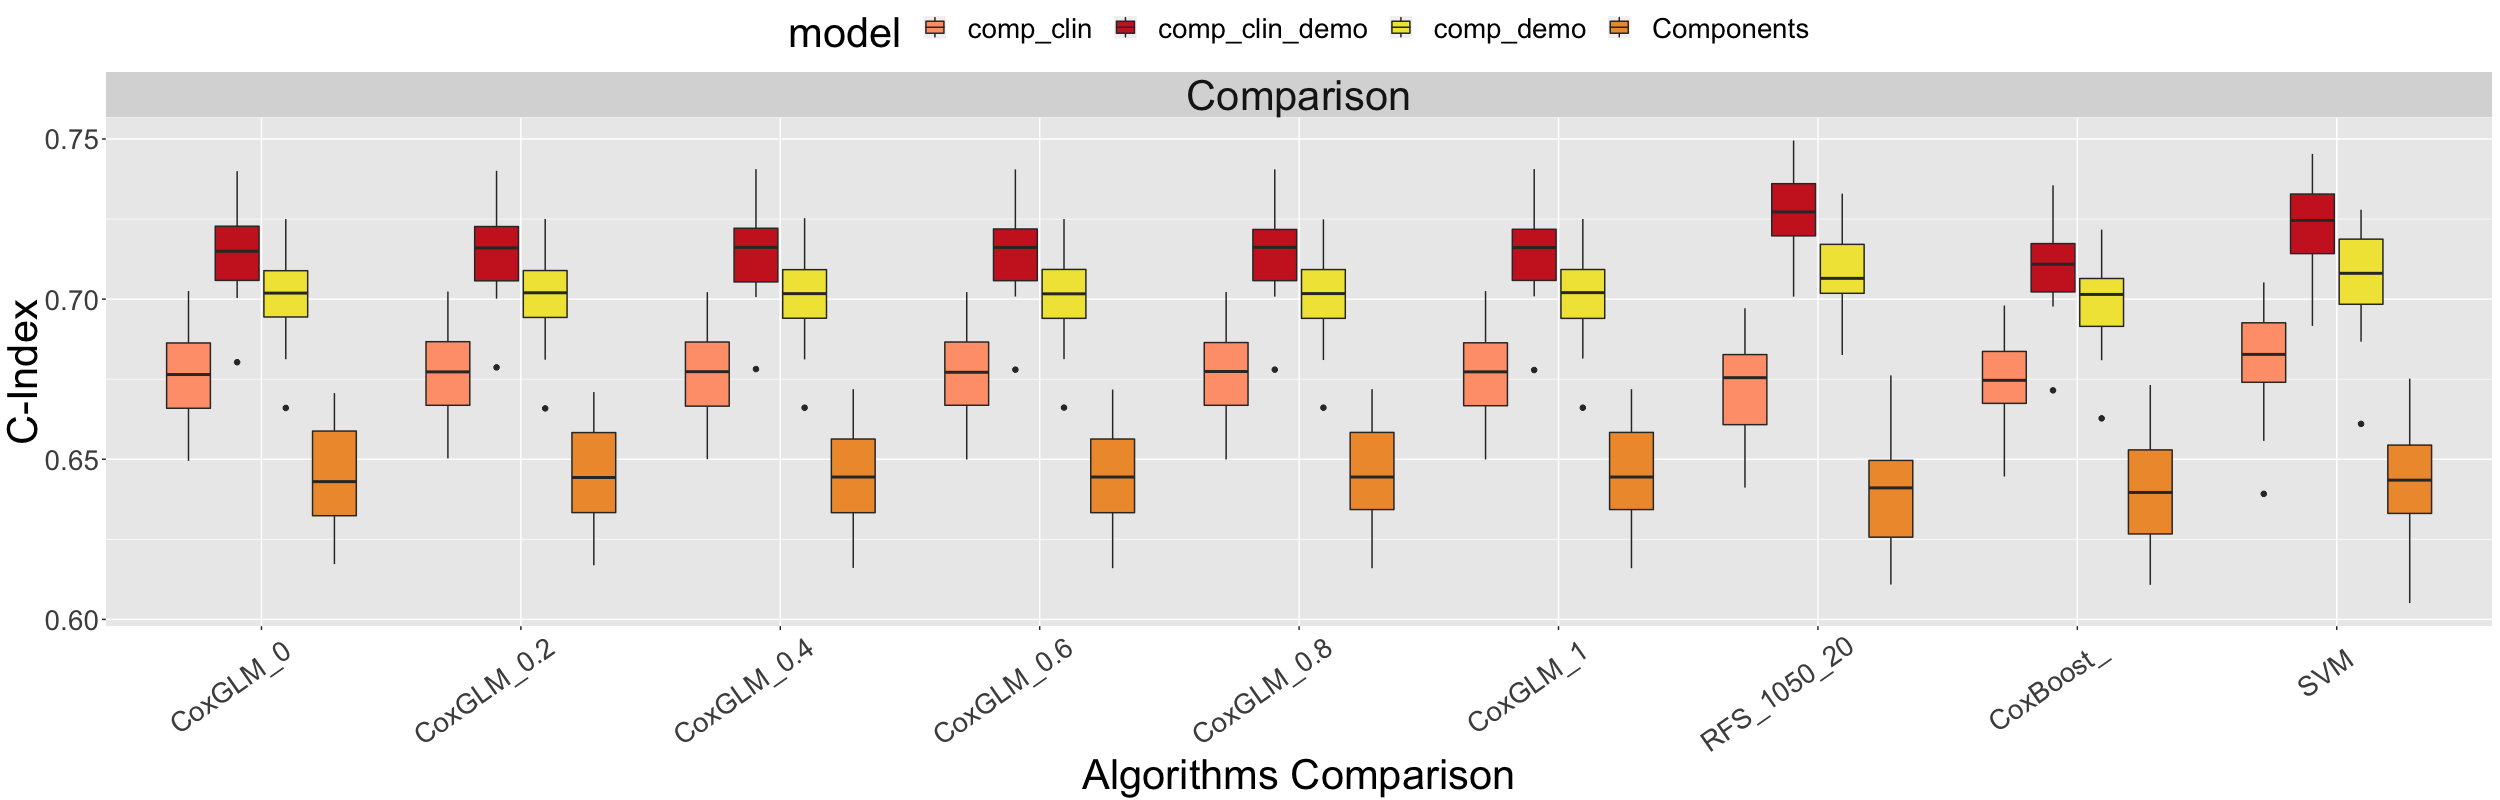

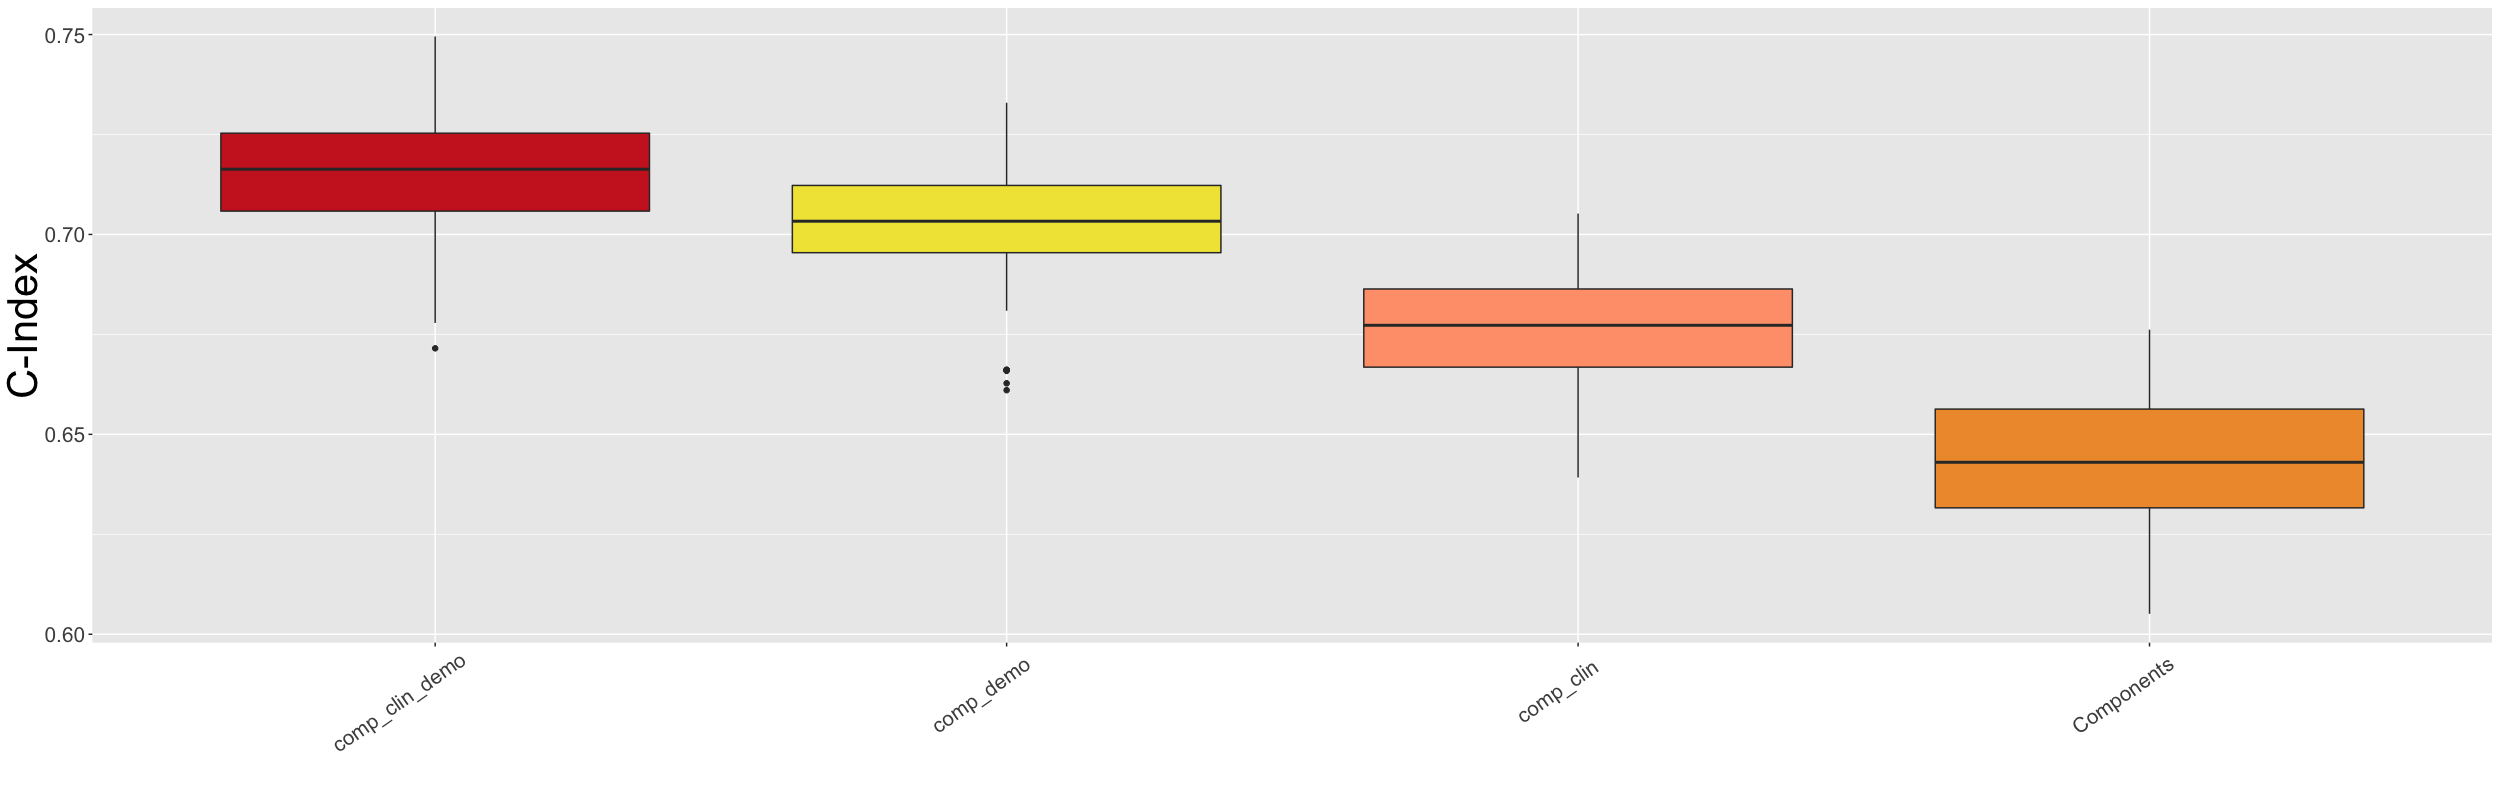

In [62]:
comparison(c("comp"
             ,"comp_demo","comp_clin","comp_clin_demo"))


# II) Comparison for Genetic and cytogenetic data

## 1) Added Value of Components , ELN  ,cytogenetic , clinical and demographical data on Genetic

[[1]]

[[2]]


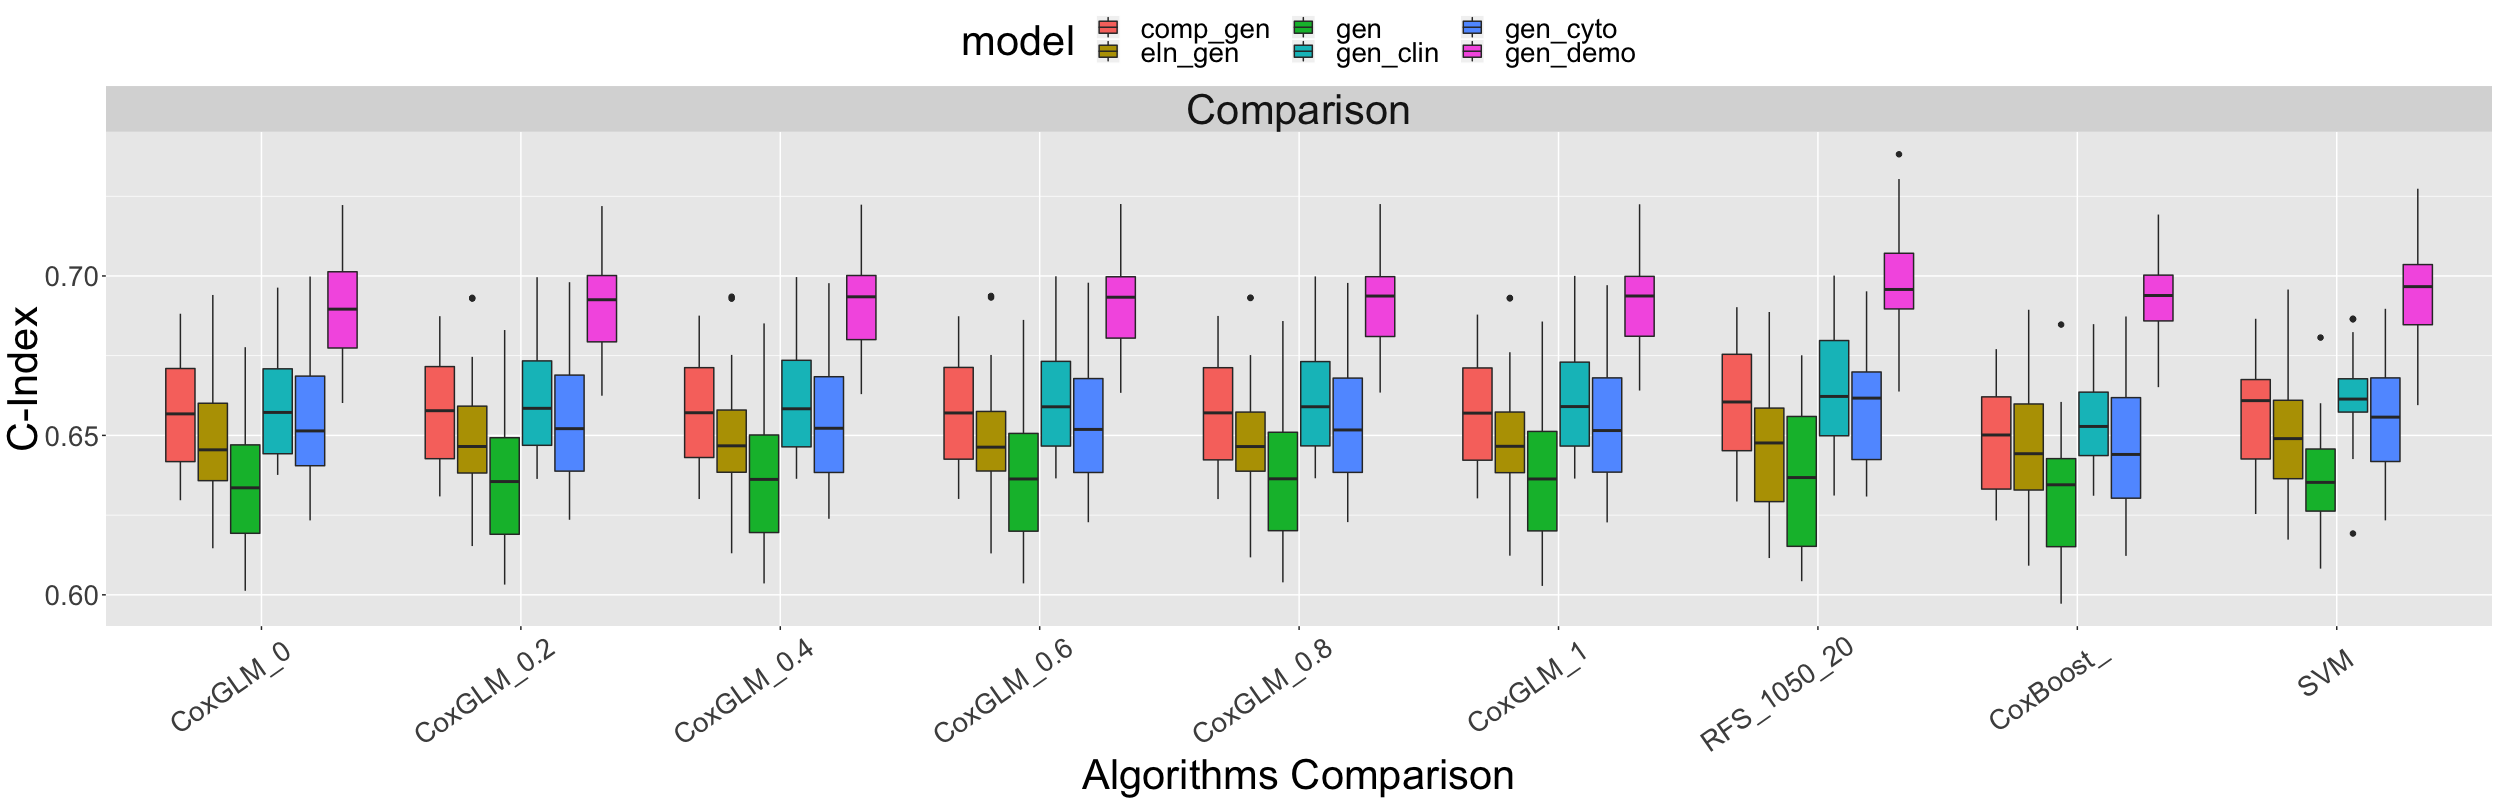

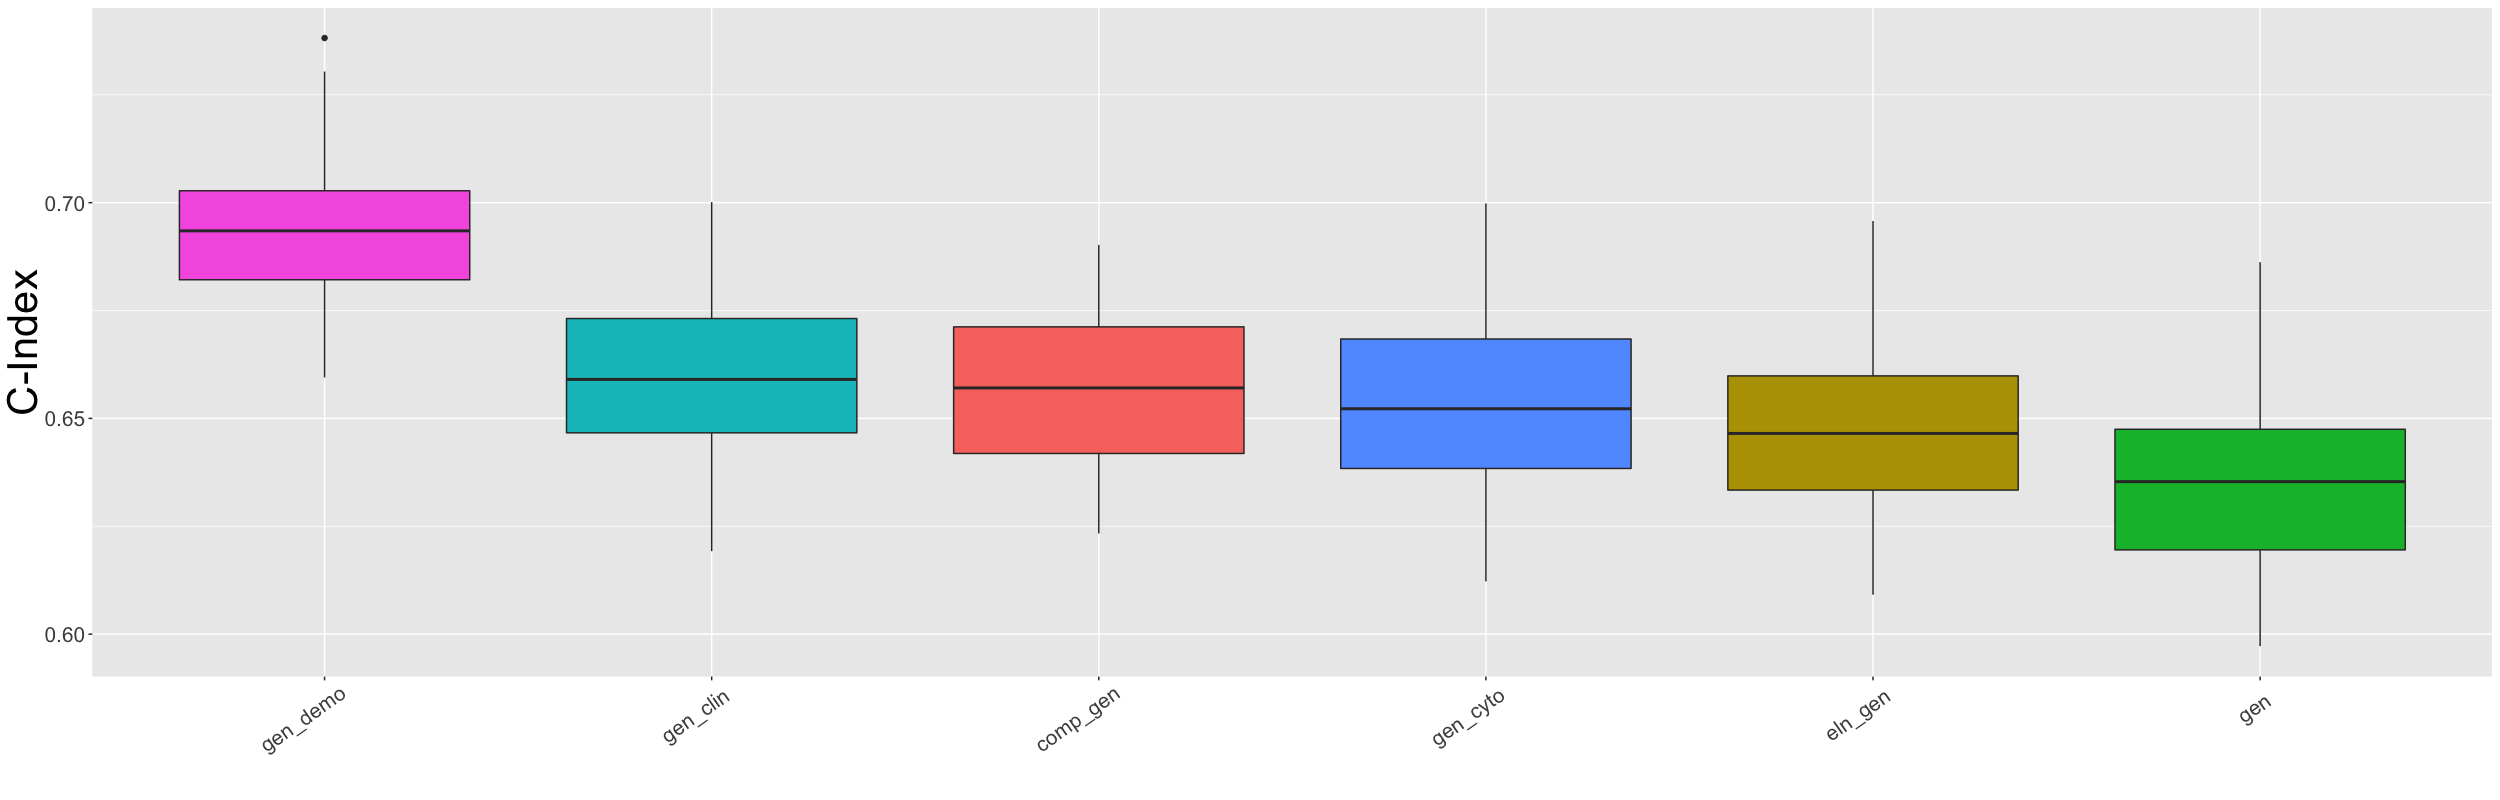

In [64]:
comparison(c("gen","comp_gen","eln_gen","gen_cyto","gen_clin","gen_demo"))

## 2) Added Value of Components , ELN ,genetic  clinical and demographical data on Genetic

#### Again, it shows that information from cyto is contained in Component but not in ELN because comp_cyto and eln_cyto performs similarly

[[1]]

[[2]]


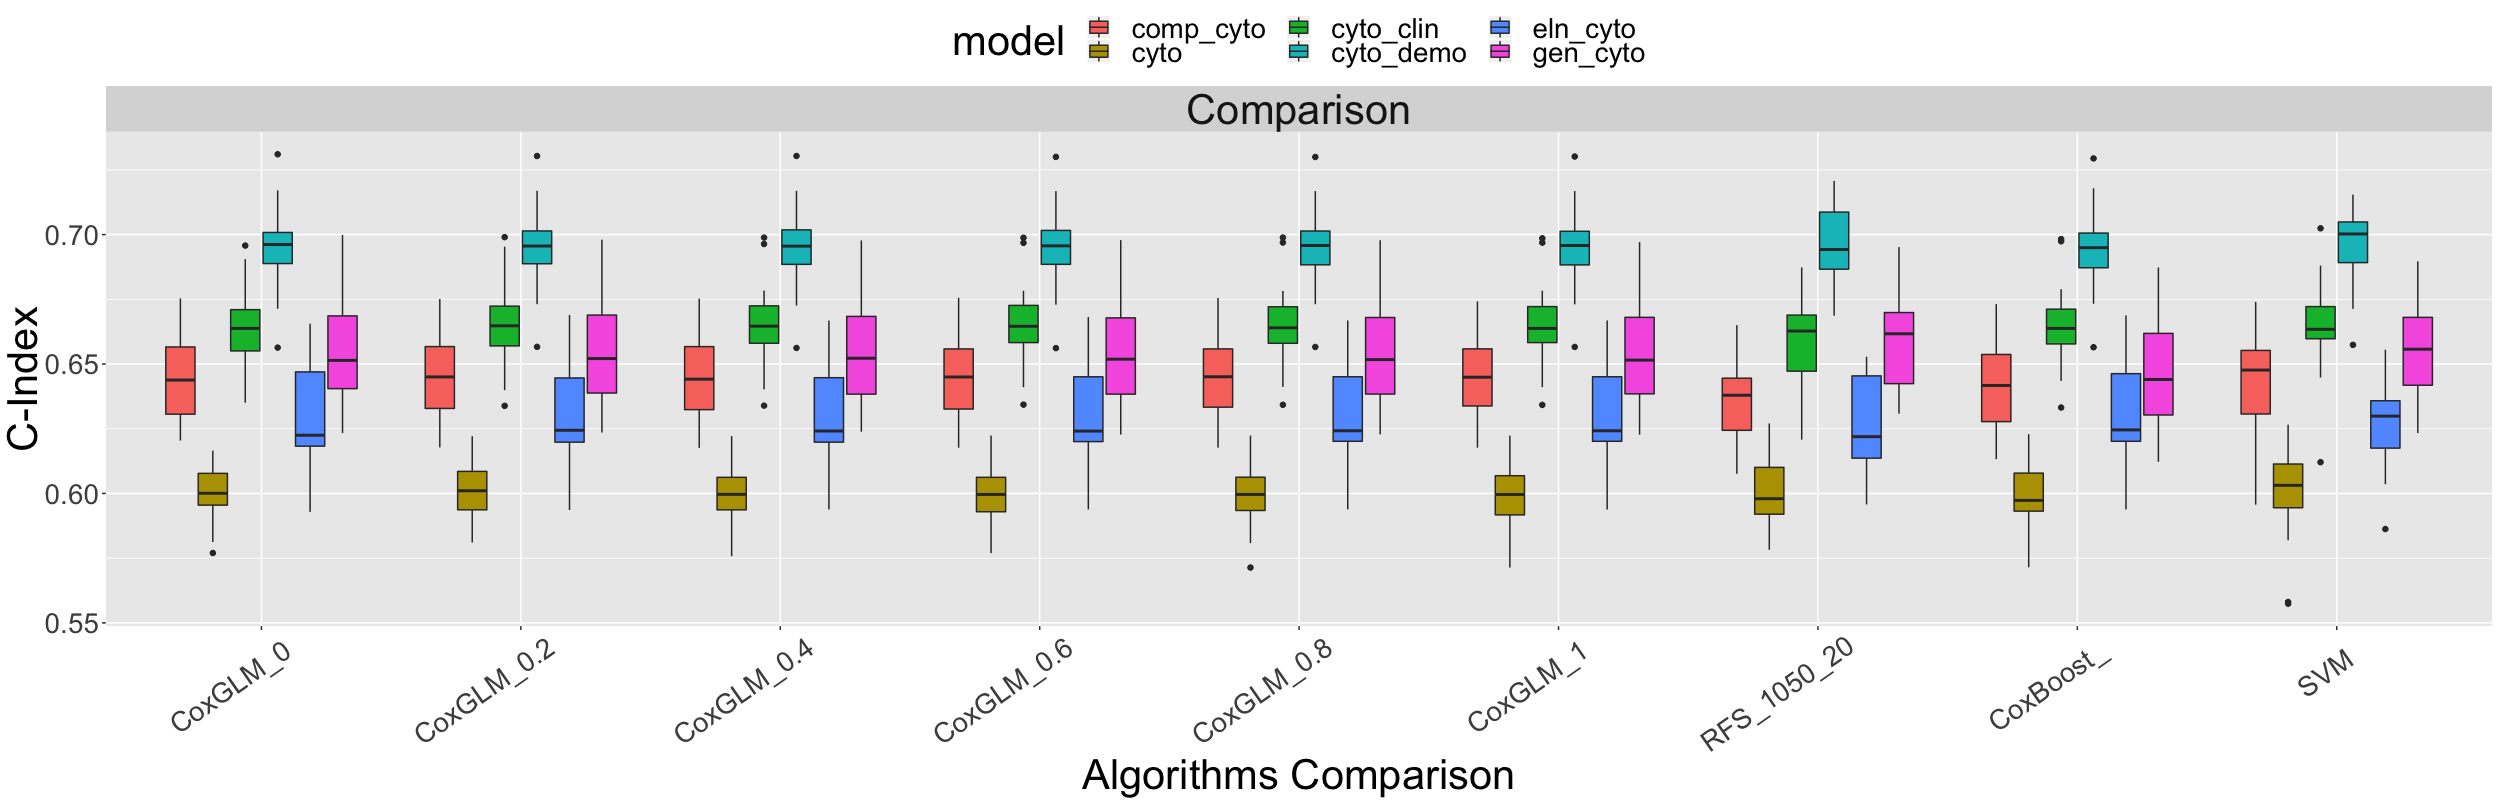

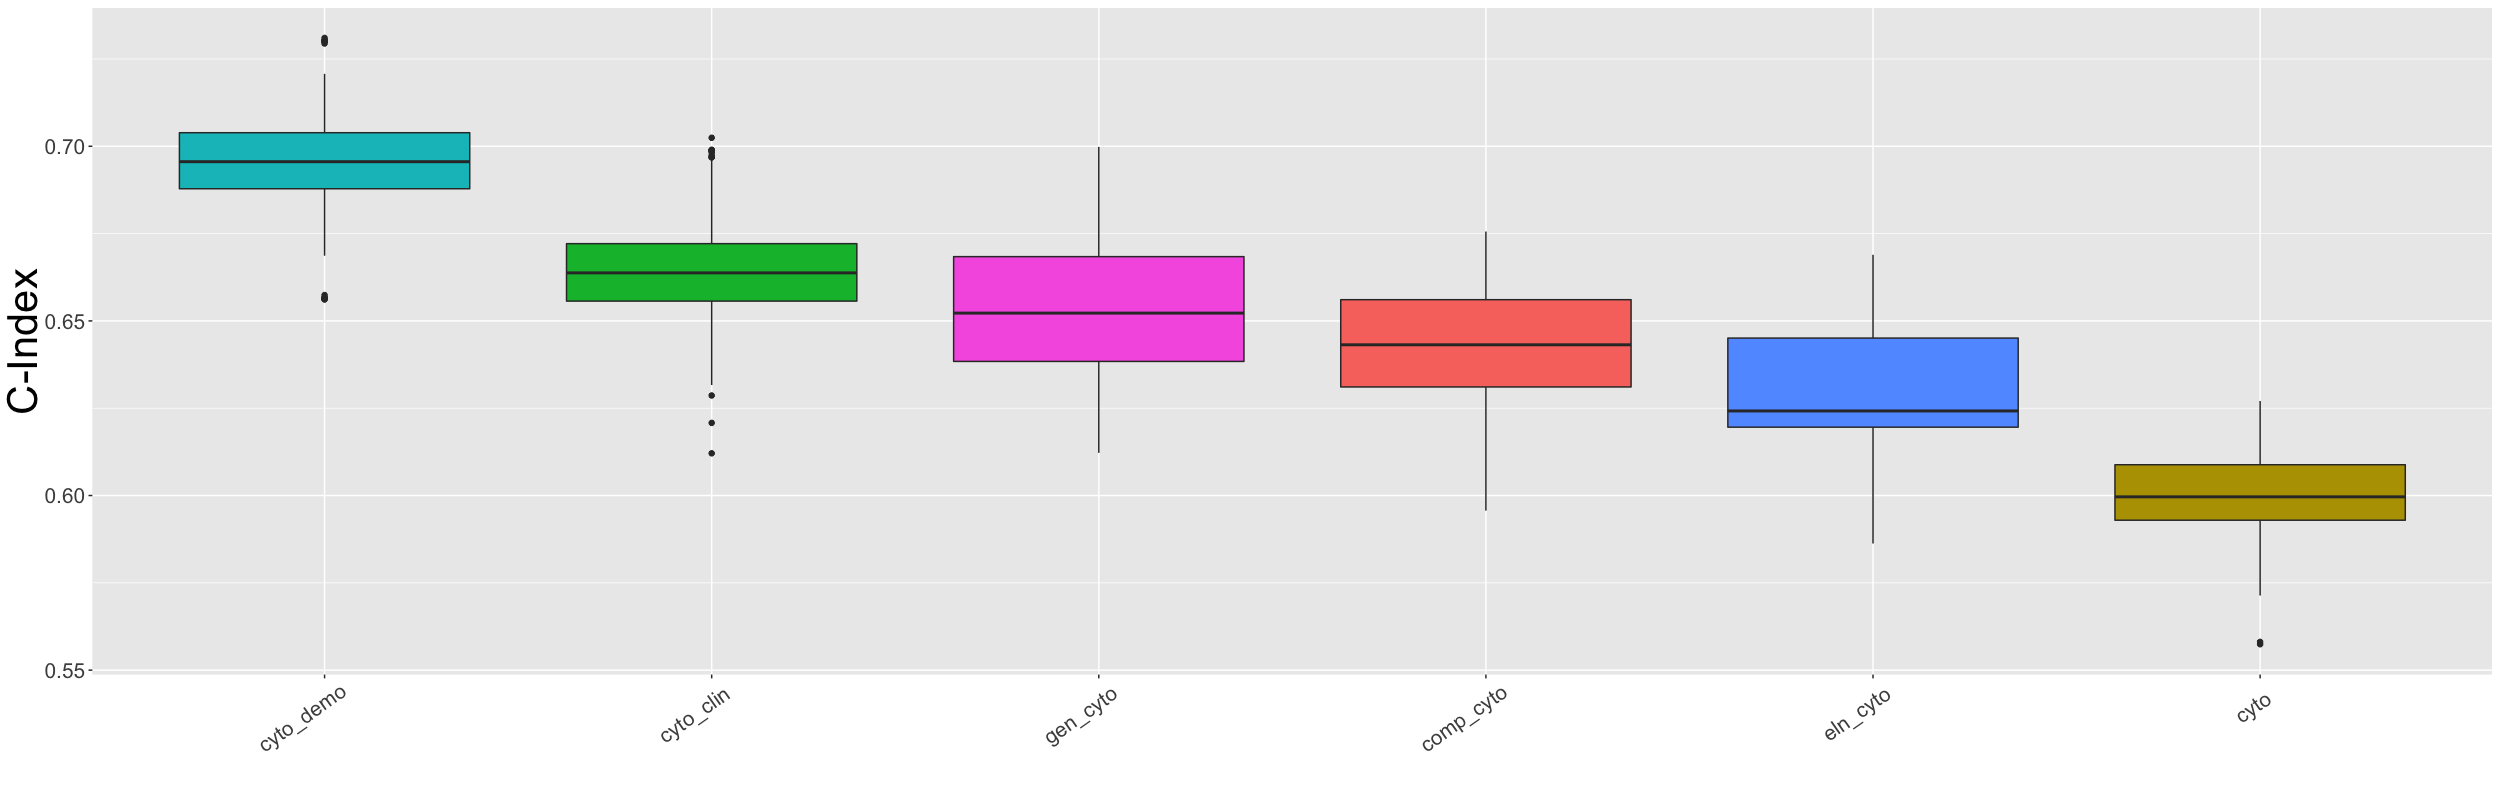

In [66]:
comparison(c("cyto","comp_cyto","eln_cyto","gen_cyto","cyto_clin","cyto_demo"))

# III) Comparison for Demo and Clinical 

## 1) Added value of Components , ELN , clinical , genetic and cytogenetic on Age 

### The biggest improvement for age is component

[[1]]

[[2]]


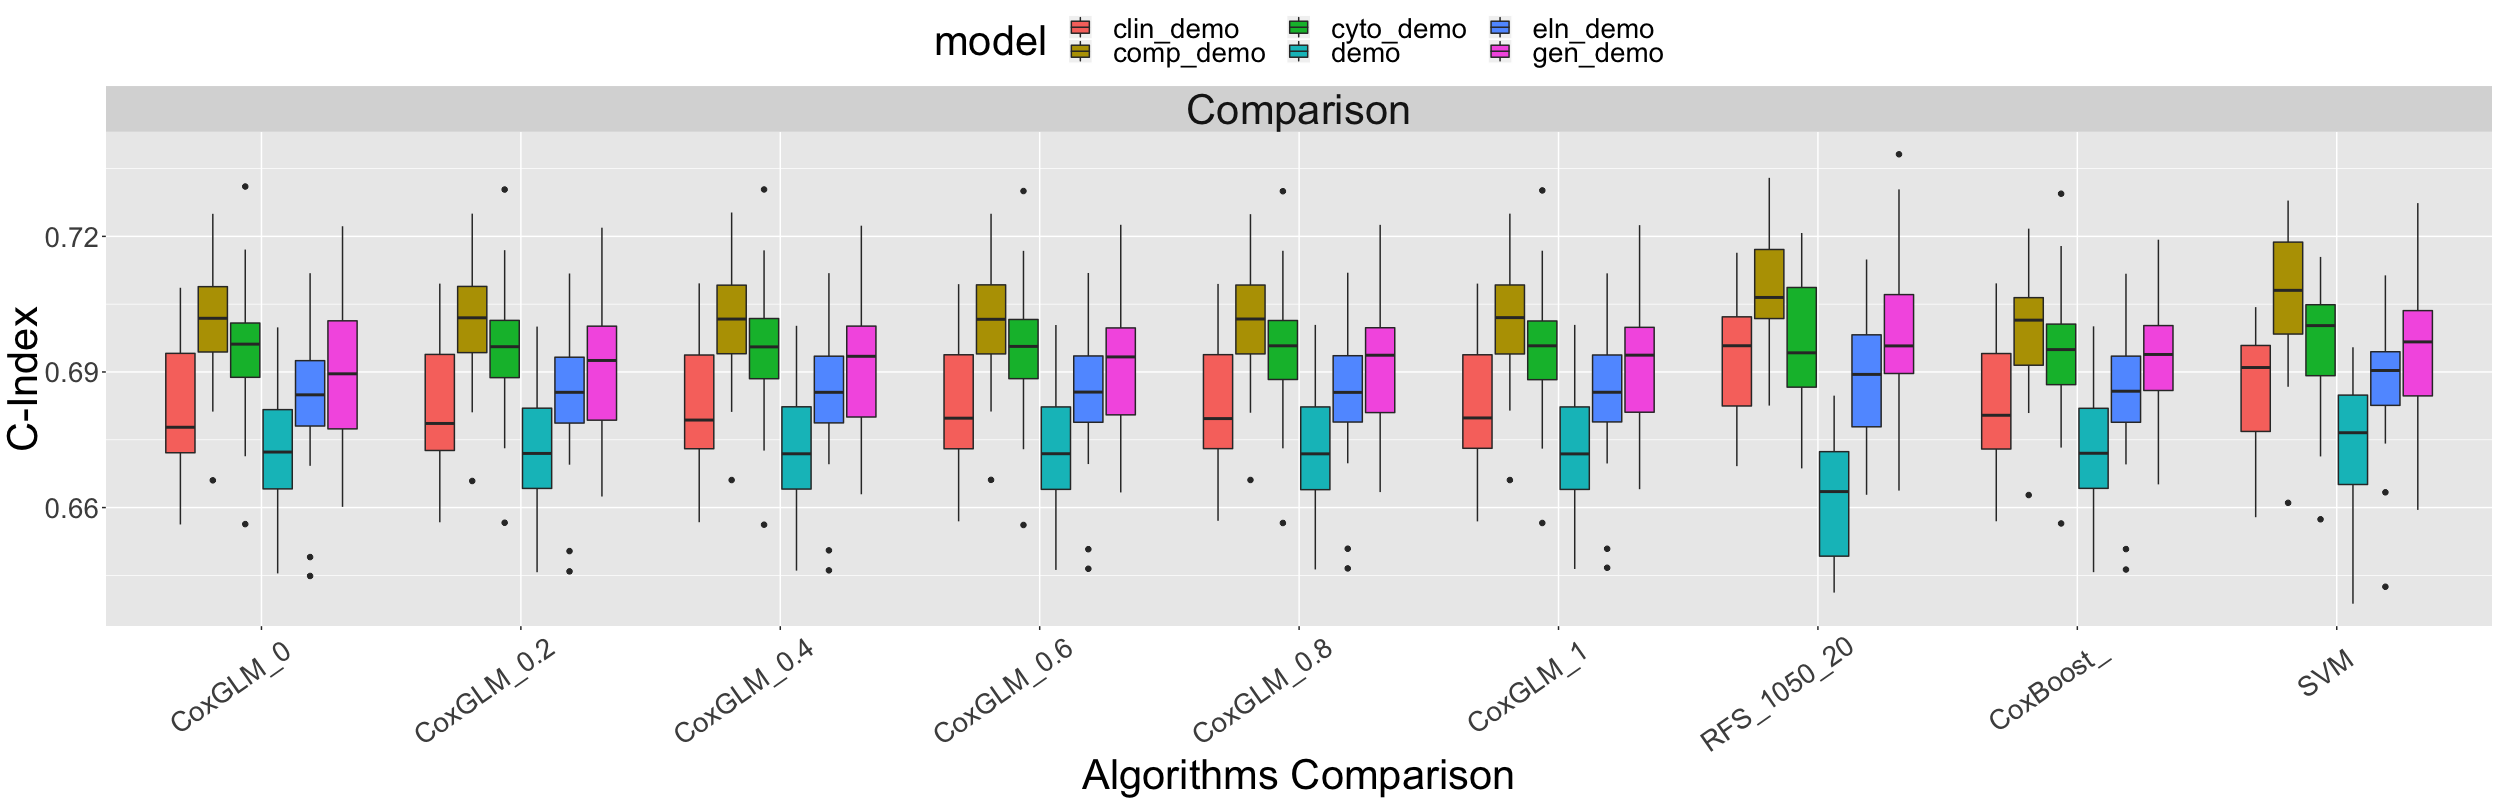

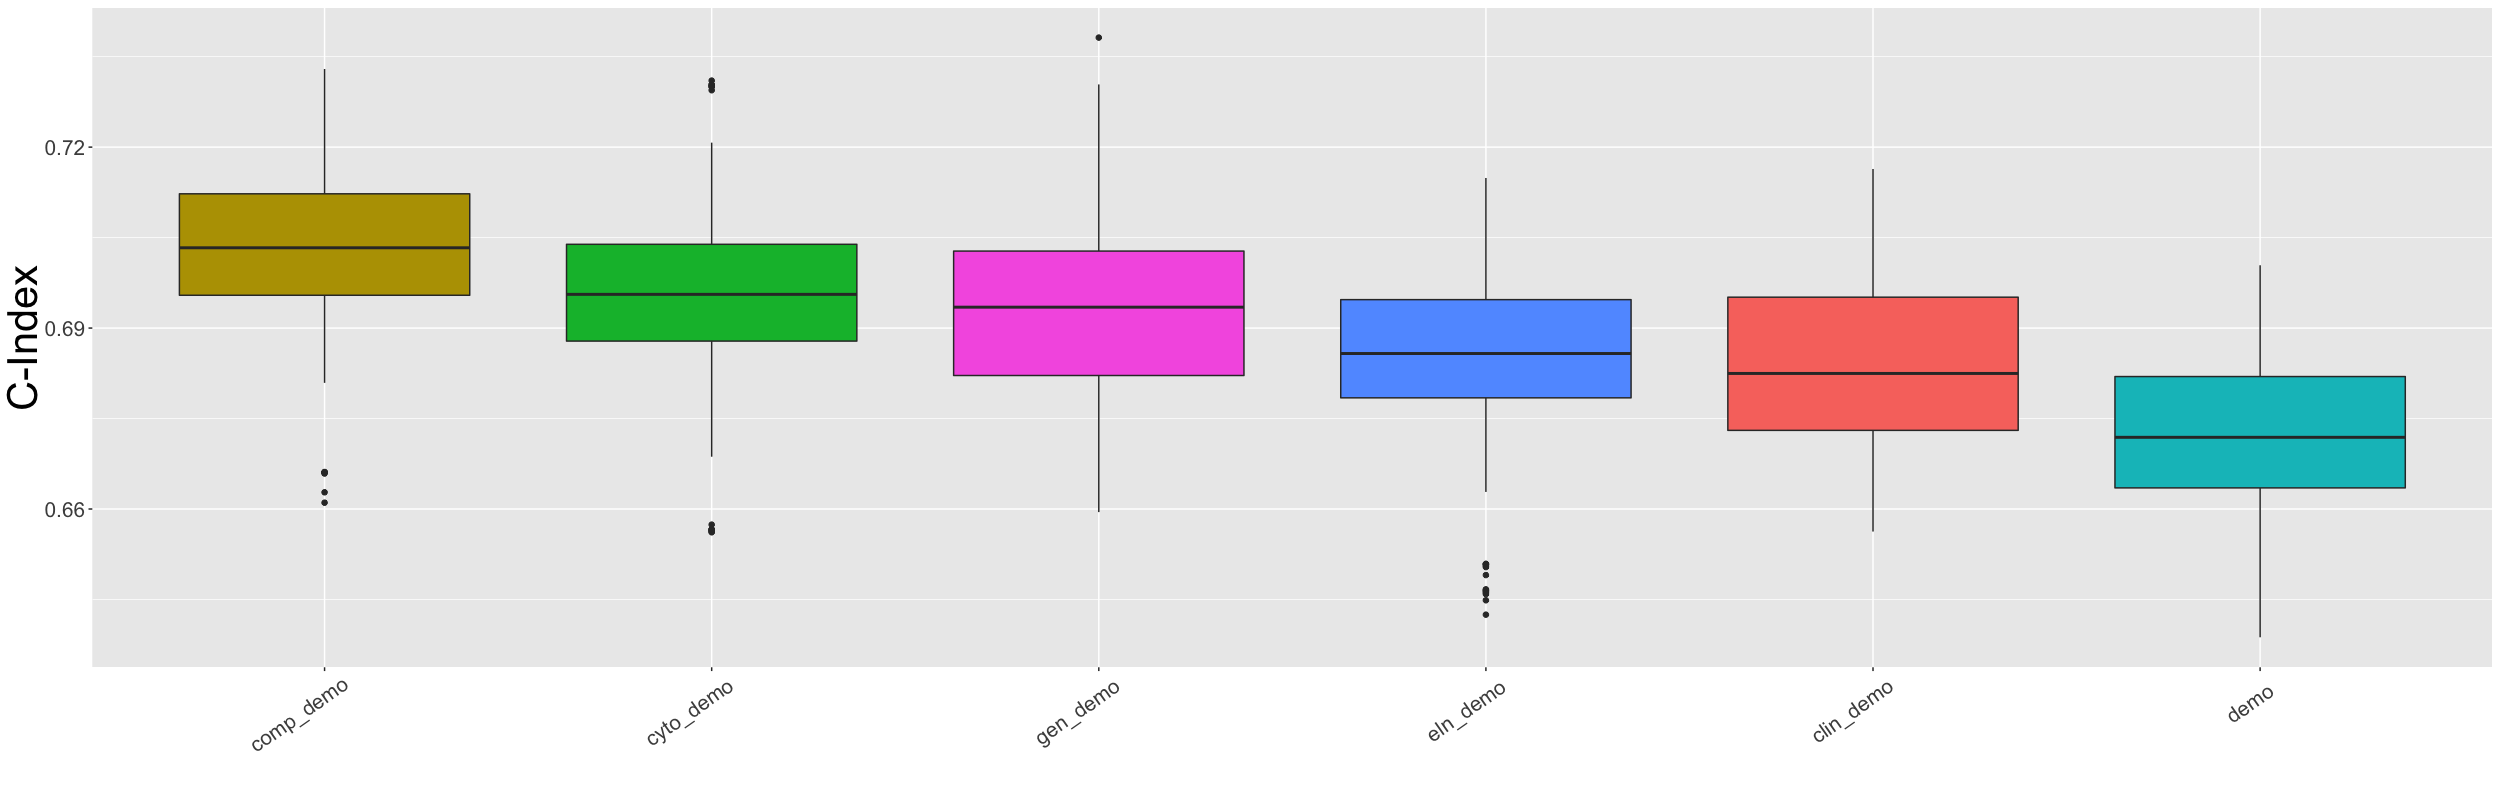

In [67]:
comparison(c("gen_demo","comp_demo","eln_demo","clin_demo","cyto_demo","demo"))

## 2) Added value of Components , ELN , age , genetic and cytogenetic on clinical

[[1]]

[[2]]


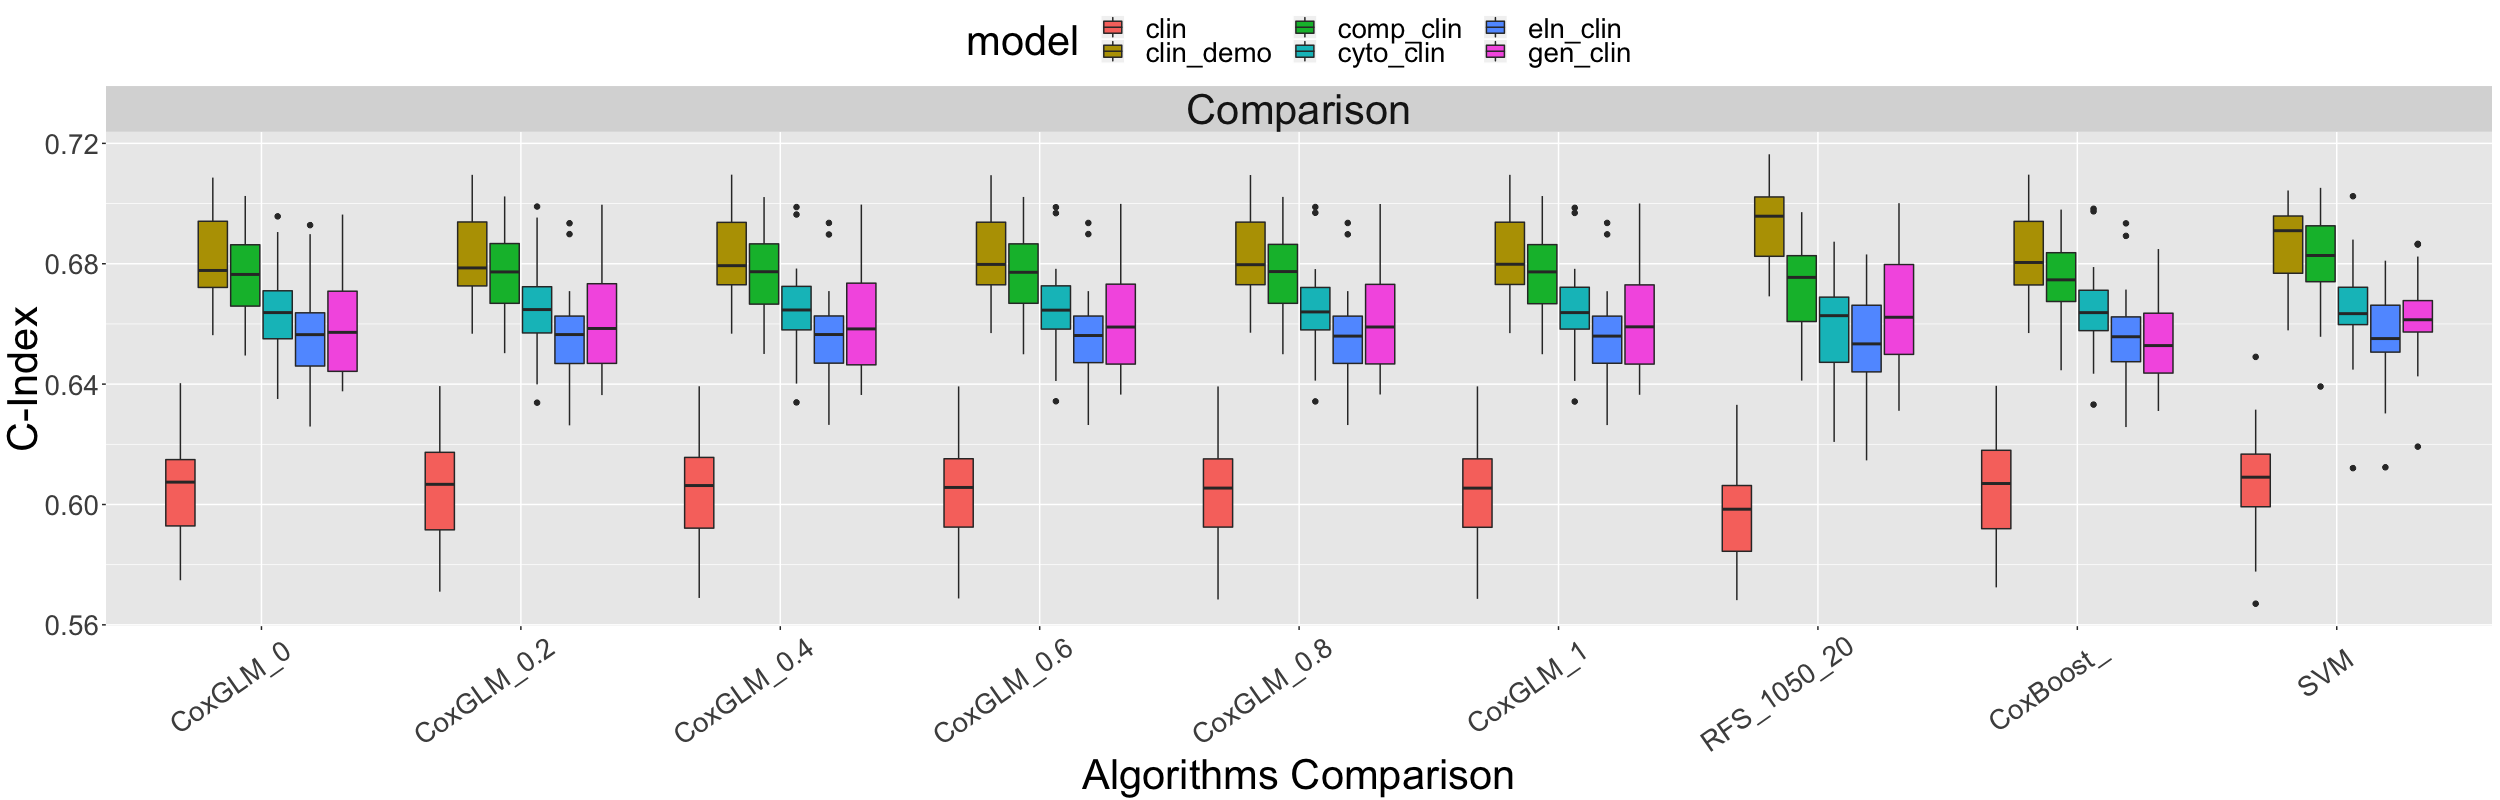

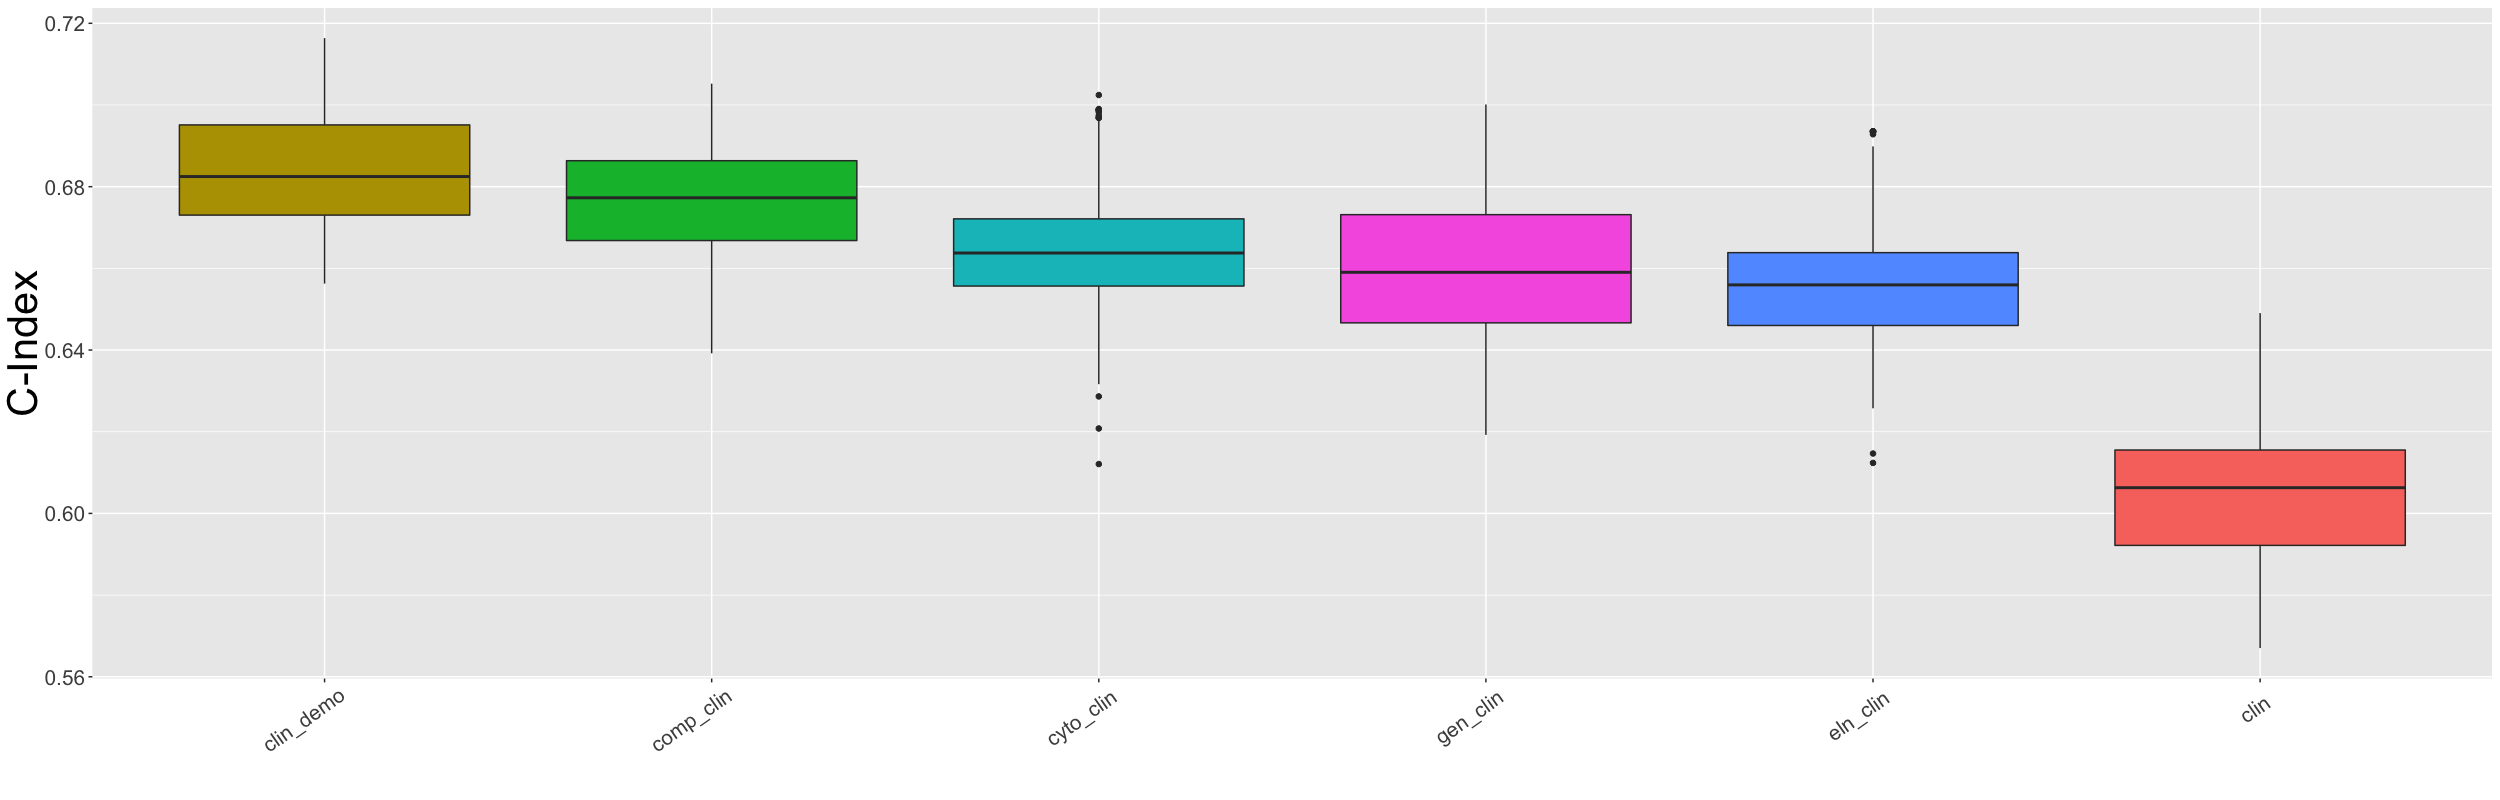

In [68]:
comparison(c("gen_clin","comp_clin","eln_clin","clin_demo","cyto_clin","clin"))